In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import Table

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency

from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import ttest_ind

from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [3]:
df = pd.read_excel('Dataset.xlsx')

## Clean Data

In [4]:
# Get the list of columns to convert to categorical
categorical_columns = df.select_dtypes(include='int64').columns.tolist()

# Convert the selected columns to categorical
df[categorical_columns] = df[categorical_columns].astype('category')

numeric_data = df.select_dtypes(include=[np.number])

# Calculate MAD for each column
mad = numeric_data.mad()

# Choose a threshold multiplier
k = 3

# Calculate the threshold value
threshold = k * mad

# Identify outliers
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Apply logarithm to the specified columns
outlier_columns = ['CommissionSacrificePercentage', 'BonusCommissionPercentage']
for column in outlier_columns:
    df[column] = np.log1p(df[column])

numeric_data = df.select_dtypes(include=[np.number])

# Check that all outliers have been handled
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Count the number of outliers in each column
outlier_counts = outliers.sum()

# Create a new DataFrame from outlier_counts
outlier_table = pd.DataFrame({'Column': outlier_counts.index, 'Outlier Count': outlier_counts.values})

# Display the table
print(outlier_table)


                          Column  Outlier Count
0  CommissionSacrificePercentage              0
1      BonusCommissionPercentage              0


In [5]:
df = df.drop(columns=['PropDate'])

X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create new DataFrames for training and testing data
df = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


# Feature Importance Techniques

In [20]:
# Define features and target variable
features = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']
target = 'PolicyIssued'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])


### Random Forest Feature Importance Scoring

In [6]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [7]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Initialise an empty dictionary to store feature importances (MDRAUC values)
feature_importances_mdrauc = {}

# Calculate the ROC AUC for the entire dataset
baseline_roc_auc = roc_auc_score(y_train, rf_classifier.predict_proba(X_train)[:, 1])

# Loop through each feature and calculate MDRAUC
for feature in features:
    # Make a copy of the dataset with the feature removed
    X_temp = X_train.copy()
    X_temp[feature] = np.random.permutation(X_temp[feature])  # Shuffle the feature values

    # Calculate ROC AUC with the shuffled feature
    shuffled_roc_auc = roc_auc_score(y_train, rf_classifier.predict_proba(X_temp)[:, 1])

    # Calculate MDRAUC for the feature
    feature_importances_mdrauc[feature] = baseline_roc_auc - shuffled_roc_auc

# Convert the dictionary to a pandas Series and sort by MDRAUC values
feature_importances_mdrauc_series = pd.Series(feature_importances_mdrauc).sort_values(ascending=False)

# Print feature importances (MDRAUC values)
print("Feature Importances (MDRAUC):")
print(feature_importances_mdrauc_series)


Feature Importances (MDRAUC):
Agency                     0.202752
WorkflowStatus             0.183774
UWDecision                 0.103240
BonusCommission            0.079233
NoOfLives                  0.070636
SignedDecReceived          0.069008
CommissionTerms            0.043526
Indexation                 0.039767
CommDateProvided           0.037879
SeriousIllnessType         0.037654
ProductGroup               0.031192
Product                    0.028594
ComissionSacrifice         0.009190
CommissionSacrificeType    0.007721
ProductType                0.007295
RenewalSacrificeType       0.004734
Discount                   0.002244
PaymentFreq                0.001468
FreeCover                  0.000464
dtype: float64


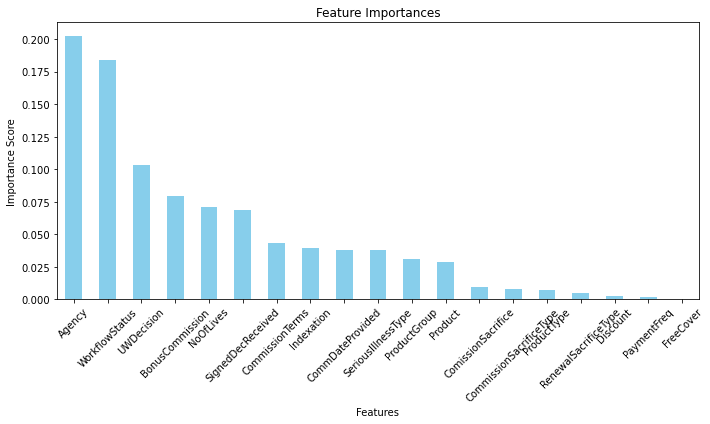

In [8]:
# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances_mdrauc_series.plot(kind='bar', color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Select the top-n features based on importance
n = 19
selected_features = feature_importances_mdrauc_series[:n].index.tolist()


In [10]:
# Create a new dataset with the selected features
selected_data = df[selected_features + [target]]


In [11]:
# Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature combination
feature_importances_mdrauc = {}

# Define the range of feature combinations to experiment with (1 to n)
for feature_combination in range(1, n + 1):
    selected_features_combination = selected_features[:feature_combination]
    X_train_combination = X_train[selected_features_combination]
    X_test_combination = X_test[selected_features_combination]

    rf_classifier_combination = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_combination.fit(X_train_combination, y_train)

    # Calculate the ROC AUC for the entire dataset with the selected feature combination
    baseline_roc_auc = roc_auc_score(y_test, rf_classifier_combination.predict_proba(X_test_combination)[:, 1])

    # Loop through each feature in the combination and calculate MDRAUC
    for feature in selected_features_combination:
        # Make a copy of the dataset with the feature removed
        X_temp = X_test_combination.copy()
        X_temp[feature] = np.random.permutation(X_temp[feature])  # Shuffle the feature values

        # Calculate ROC AUC with the shuffled feature
        shuffled_roc_auc = roc_auc_score(y_test, rf_classifier_combination.predict_proba(X_temp)[:, 1])

        # Calculate MDRAUC for the feature in this combination
        feature_importances_mdrauc[(feature_combination, feature)] = baseline_roc_auc - shuffled_roc_auc

# Print feature importances (MDRAUC values) for each feature combination
for feature_combination in range(1, n + 1):
    print(f"\nExperiment with {feature_combination} features:")
    selected_features_combination = selected_features[:feature_combination]
    print(f"Selected Features: {selected_features_combination}")

    # Filter the feature importances for this combination
    combination_importances = {
        feature: importance
        for (combination, feature), importance in feature_importances_mdrauc.items()
        if combination == feature_combination
    }

    # Sort the feature importances for this combination
    combination_importances_series = pd.Series(combination_importances).sort_values(ascending=False)
    
    # Print feature importances (MDRAUC values) for this combination
    print("Feature Importances (MDRAUC):")
    print(combination_importances_series)


Experiment with 1 features:
Selected Features: ['Agency']
Feature Importances (MDRAUC):
Agency    0.106753
dtype: float64

Experiment with 2 features:
Selected Features: ['Agency', 'WorkflowStatus']
Feature Importances (MDRAUC):
WorkflowStatus    0.263558
Agency            0.066000
dtype: float64

Experiment with 3 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision']
Feature Importances (MDRAUC):
WorkflowStatus    0.247593
Agency            0.066134
UWDecision        0.018753
dtype: float64

Experiment with 4 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'BonusCommission']
Feature Importances (MDRAUC):
WorkflowStatus     0.209694
Agency             0.070705
UWDecision         0.028334
BonusCommission    0.011731
dtype: float64

Experiment with 5 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'BonusCommission', 'NoOfLives']
Feature Importances (MDRAUC):
WorkflowStatus     0.193493
Agency             0.068138
UWDecisi

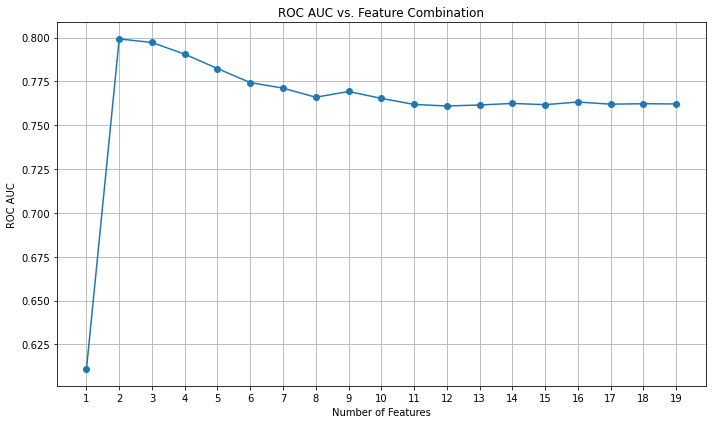


Experiment with 1 features:
Selected Features: ['Agency']
Feature Importances (MDRAUC):
Agency    0.107198
dtype: float64

Experiment with 2 features:
Selected Features: ['Agency', 'WorkflowStatus']
Feature Importances (MDRAUC):
WorkflowStatus    0.254850
Agency            0.067562
dtype: float64

Experiment with 3 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision']
Feature Importances (MDRAUC):
WorkflowStatus    0.250359
Agency            0.063249
UWDecision        0.022142
dtype: float64

Experiment with 4 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'BonusCommission']
Feature Importances (MDRAUC):
WorkflowStatus     0.211762
Agency             0.071544
UWDecision         0.029012
BonusCommission    0.008714
dtype: float64

Experiment with 5 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'BonusCommission', 'NoOfLives']
Feature Importances (MDRAUC):
WorkflowStatus     0.192911
Agency             0.063852
UWDecisi

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Initialise empty lists to store results
feature_combinations = []
roc_auc_scores = []

# Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature combination
feature_importances_mdrauc = {}

# Define the range of feature combinations to experiment with (1 to n)
for feature_combination in range(1, n + 1):
    selected_features_combination = selected_features[:feature_combination]
    X_train_combination = X_train[selected_features_combination]
    X_test_combination = X_test[selected_features_combination]

    rf_classifier_combination = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_combination.fit(X_train_combination, y_train)

    # Calculate ROC AUC for the entire dataset with the selected feature combination
    y_proba_combination = rf_classifier_combination.predict_proba(X_test_combination)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba_combination)

    # Append results to lists
    feature_combinations.append(feature_combination)
    roc_auc_scores.append(roc_auc)

    # Loop through each feature in the combination and calculate MDRAUC
    for feature in selected_features_combination:
        # Make a copy of the dataset with the feature removed
        X_temp = X_test_combination.copy()
        X_temp[feature] = np.random.permutation(X_temp[feature])  # Shuffle the feature values

        # Calculate ROC AUC with the shuffled feature
        shuffled_y_proba = rf_classifier_combination.predict_proba(X_temp)[:, 1]
        shuffled_roc_auc = roc_auc_score(y_test, shuffled_y_proba)

        # Calculate MDRAUC for the feature in this combination
        feature_importances_mdrauc[(feature_combination, feature)] = roc_auc - shuffled_roc_auc

# Create a line plot for ROC AUC vs. Feature Combination
plt.figure(figsize=(10, 6))
plt.plot(feature_combinations, roc_auc_scores, marker='o', linestyle='-')
plt.title("ROC AUC vs. Feature Combination")
plt.xlabel("Number of Features")
plt.ylabel("ROC AUC")
plt.xticks(np.arange(1, n + 1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Print feature importances (MDRAUC values) for each feature combination
for feature_combination in range(1, n + 1):
    print(f"\nExperiment with {feature_combination} features:")
    selected_features_combination = selected_features[:feature_combination]
    print(f"Selected Features: {selected_features_combination}")

    # Filter the feature importances for this combination
    combination_importances = {
        feature: importance
        for (combination, feature), importance in feature_importances_mdrauc.items()
        if combination == feature_combination
    }

    # Sort the feature importances for this combination
    combination_importances_series = pd.Series(combination_importances).sort_values(ascending=False)
    
    # Print feature importances (MDRAUC values) for this combination
    print("Feature Importances (MDRAUC):")
    print(combination_importances_series)


#### Try different test sizes and different n estimators

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import numpy as np
import pandas as pd

# Define different n estimator values to test
n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

# Iterate through each n estimator value
for n_estimators_value in n_estimators_values:
    # Split the data into training and testing sets with the current test size
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])

    # Train a Random Forest classifier with the current n estimator value
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Get feature importances
    feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

    # Print feature importances for the current n estimator value
    print(f"\n n_estimators: {n_estimators_value}")
    print("Feature Importances:")
    print(feature_importances)

    # Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature combination
    feature_importances_mdrauc = {}

    # Select the top-n features based on importance
    for n in n_values:
        selected_features = feature_importances[:n].index.tolist()

        # Create a new dataset with the selected features
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier_selected.fit(X_train_selected, y_train)

        # Calculate ROC AUC for the entire dataset with the selected feature combination
        y_proba_selected = rf_classifier_selected.predict_proba(X_test_selected)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba_selected)

        # Append results to the dictionary
        feature_importances_mdrauc[n] = roc_auc

        # Calculate y_pred_selected for accuracy and classification report
        y_pred_selected = rf_classifier_selected.predict(X_test_selected)

        accuracy = accuracy_score(y_test, y_pred_selected)
        report = classification_report(y_test, y_pred_selected)
        print(f"Selected Features: {selected_features}")
        print(f"ROC AUC: {roc_auc}")
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{report}")

    # Print feature importances (MDRAUC values) for the current n estimator value
    print("Feature Importances (MDRAUC):")
    print(feature_importances_mdrauc)



 n_estimators: 50
Feature Importances:
Agency                     0.568212
WorkflowStatus             0.177457
UWDecision                 0.099782
CommDateProvided           0.037087
SignedDecReceived          0.014222
NoOfLives                  0.013113
BonusCommission            0.012710
ProductGroup               0.012109
SeriousIllnessType         0.011081
CommissionTerms            0.010930
Product                    0.010863
Indexation                 0.009646
ProductType                0.005605
CommissionSacrificeType    0.003944
RenewalSacrificeType       0.003862
ComissionSacrifice         0.003201
Discount                   0.002941
PaymentFreq                0.002637
FreeCover                  0.000598
dtype: float64
Selected Features: ['Agency']
ROC AUC: 0.6105233478072118
Accuracy: 0.7791113583975836
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.04      0.07      5578
           1       0.78      0.99      0.8

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'ProductGroup', 'SeriousIllnessType', 'CommissionTerms', 'Product', 'Indexation', 'ProductType', 'CommissionSacrificeType', 'RenewalSacrificeType']
ROC AUC: 0.7588309223384586
Accuracy: 0.7799856927112312
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.40      0.45      5578
           1       0.84      0.89      0.86     19584

    accuracy                           0.78     25162
   macro avg       0.67      0.64      0.65     25162
weighted avg       0.76      0.78      0.77     25162

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'ProductGroup', 'SeriousIllnessType', 'CommissionTerms', 'Product', 'Indexation', 'ProductType', 'CommissionSacrificeType', 'RenewalSacrificeType', 'ComissionSacrifice']
ROC A

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product']
ROC AUC: 0.7665905614479269
Accuracy: 0.7832445751530085
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      5578
           1       0.84      0.89      0.87     19584

    accuracy                           0.78     25162
   macro avg       0.68      0.65      0.66     25162
weighted avg       0.77      0.78      0.77     25162

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product', 'SeriousIllnessType']
ROC AUC: 0.7625407736933963
Accuracy: 0.7814561640569112
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      5578
           1       0.84      0.89      0.86     19584

    accuracy                       


 n_estimators: 200
Feature Importances:
Agency                     0.567266
WorkflowStatus             0.192298
UWDecision                 0.089511
CommDateProvided           0.033970
SignedDecReceived          0.013956
NoOfLives                  0.013573
BonusCommission            0.012193
Product                    0.011795
SeriousIllnessType         0.011183
ProductGroup               0.011103
CommissionTerms            0.010966
Indexation                 0.009650
ProductType                0.005328
RenewalSacrificeType       0.003923
CommissionSacrificeType    0.003827
ComissionSacrifice         0.003242
Discount                   0.003098
PaymentFreq                0.002655
FreeCover                  0.000463
dtype: float64
Selected Features: ['Agency']
ROC AUC: 0.6106311796298836
Accuracy: 0.7795882680232096
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.04      0.07      5578
           1       0.78      0.99      0.

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product', 'SeriousIllnessType', 'ProductGroup', 'CommissionTerms', 'Indexation', 'ProductType', 'RenewalSacrificeType', 'CommissionSacrificeType']
ROC AUC: 0.7643418063450133
Accuracy: 0.7813766791193069
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      5578
           1       0.84      0.89      0.86     19584

    accuracy                           0.78     25162
   macro avg       0.67      0.65      0.66     25162
weighted avg       0.77      0.78      0.77     25162

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product', 'SeriousIllnessType', 'ProductGroup', 'CommissionTerms', 'Indexation', 'ProductType', 'RenewalSacrificeType', 'CommissionSacrificeType', 'ComissionSacrifice']
ROC A


 n_estimators: 50
Feature Importances:
Agency                     0.568212
WorkflowStatus             0.177457
UWDecision                 0.099782
CommDateProvided           0.037087
SignedDecReceived          0.014222
NoOfLives                  0.013113
BonusCommission            0.012710
ProductGroup               0.012109
SeriousIllnessType         0.011081
CommissionTerms            0.010930
Product                    0.010863
Indexation                 0.009646
ProductType                0.005605
CommissionSacrificeType    0.003944
RenewalSacrificeType       0.003862
ComissionSacrifice         0.003201
Discount                   0.002941
PaymentFreq                0.002637
FreeCover                  0.000598
dtype: float64
Selected Features: ['Agency']
ROC AUC: 0.6105233478072118
Selected Features: ['Agency', 'WorkflowStatus']
ROC AUC: 0.7990150215921794
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision']
ROC AUC: 0.7969319848547164
Selected Features: ['Agency', 'Workfl

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product', 'SeriousIllnessType', 'CommissionTerms', 'ProductGroup', 'Indexation', 'ProductType', 'CommissionSacrificeType', 'RenewalSacrificeType']
ROC AUC: 0.7623223637899943
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product', 'SeriousIllnessType', 'CommissionTerms', 'ProductGroup', 'Indexation', 'ProductType', 'CommissionSacrificeType', 'RenewalSacrificeType', 'ComissionSacrifice']
ROC AUC: 0.763963458949374
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission', 'Product', 'SeriousIllnessType', 'CommissionTerms', 'ProductGroup', 'Indexation', 'ProductType', 'CommissionSacrificeType', 'RenewalSacrificeType', 'ComissionSacrifice', 'Discount']
ROC AUC: 0.7627978875270378
Selected Fea

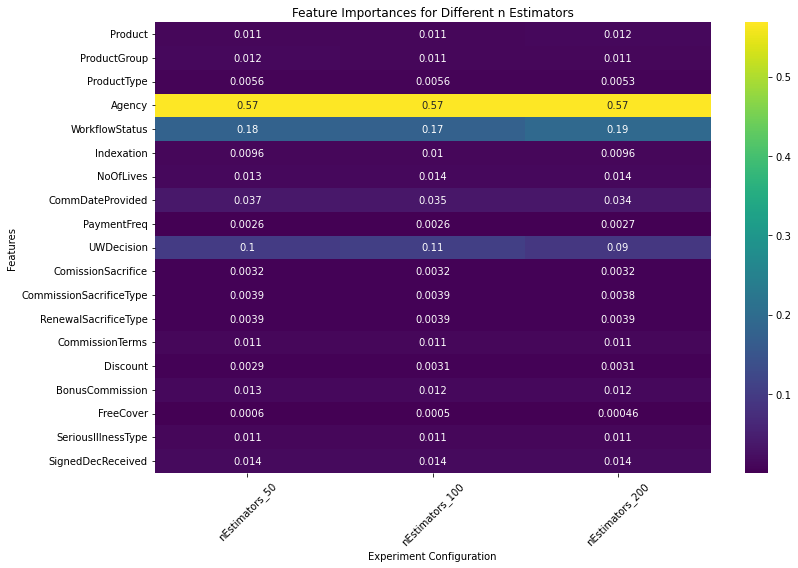

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create an empty DataFrame to store feature importances
feature_importance_df = pd.DataFrame(index=features)

n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

for n_estimators_value in n_estimators_values:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])

    # Train a Random Forest classifier with the current n estimator value
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Get feature importances
    feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

    # Print feature importances for the current experiment configuration
    print(f"\n n_estimators: {n_estimators_value}")
    print("Feature Importances:")
    print(feature_importances)

    # Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature combination
    feature_importances_mdrauc = {}

    # Select the top-n features based on importance
    for n in n_values:
        selected_features = feature_importances[:n].index.tolist()

        # Create a new dataset with the selected features
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier_selected.fit(X_train_selected, y_train)

        # Calculate ROC AUC for the entire dataset with the selected feature combination
        y_proba_selected = rf_classifier_selected.predict_proba(X_test_selected)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba_selected)

        # Append results to the dictionary
        feature_importances_mdrauc[n] = roc_auc

        # Print feature importances (MDRAUC values) for the current feature combination
        print(f"Selected Features: {selected_features}")
        print(f"ROC AUC: {roc_auc}")

    # Print feature importances (MDRAUC values) for the current experiment configuration
    print("Feature Importances (MDRAUC):")
    print(feature_importances_mdrauc)

    # Store feature importances in the DataFrame
    feature_importance_df[f"nEstimators_{n_estimators_value}"] = feature_importances

# Create a heatmap to visualise feature importances
plt.figure(figsize=(12, 8))
sns.heatmap(feature_importance_df, cmap='viridis', annot=True)
plt.title("Feature Importances for Different n Estimators")
plt.xlabel("Experiment Configuration")
plt.ylabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd
import numpy as np

# Create empty lists to store results
results = []
feature_importances_dict = {}

n_values = list(range(1, 8))

# Define different n estimator values to test
n_estimators_values = [50, 100, 200]

# Iterate through each n estimator value
for n_estimators_value in n_estimators_values:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])

    # Train a Random Forest classifier with the current n estimator value
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Get feature importances
    feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

    # Store feature importances in dictionary for visualization
    feature_importances_dict[( n_estimators_value)] = feature_importances

    # Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature combination
    feature_importances_mdrauc = {}

    # Select the top-n features based on importance
    for n in n_values:
        selected_features = feature_importances[:n].index.tolist()

        # Create a new dataset with the selected features
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier_selected.fit(X_train_selected, y_train)

        # Calculate ROC AUC for the entire dataset with the selected feature combination
        y_proba_selected = rf_classifier_selected.predict_proba(X_test_selected)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba_selected)

        # Append results to the dictionary
        feature_importances_mdrauc[n] = roc_auc

        # Calculate y_pred_selected for roc_auc calculation
        y_pred_selected = rf_classifier_selected.predict(X_test_selected)

        roc_auc = roc_auc_score(y_test, y_pred_selected)
        results.append(( n_estimators_value, n, roc_auc))

    # Print feature importances (MDRAUC values) for the current experiment configuration
    print(f"\n n_estimators: {n_estimators_value}")
    print("Feature Importances (MDRAUC):")
    print(feature_importances_mdrauc)

# Print results
print("Results:")
print(results)



 n_estimators: 50
Feature Importances (MDRAUC):
{1: 0.6105233478072118, 2: 0.7990150215921794, 3: 0.7969319848547164, 4: 0.7995199257133534, 5: 0.7925312710912619, 6: 0.7848839173196172, 7: 0.7758076168236208}

 n_estimators: 100
Feature Importances (MDRAUC):
{1: 0.610815156034327, 2: 0.7992481880555498, 3: 0.797206052254773, 4: 0.7995521027036068, 5: 0.7926577545832483, 6: 0.7855314300446784, 7: 0.777018332151344}

 n_estimators: 200
Feature Importances (MDRAUC):
{1: 0.6106311796298836, 2: 0.7989274159601095, 3: 0.7973484045412416, 4: 0.7996041717563982, 5: 0.7929336528220108, 6: 0.7858193431624473, 7: 0.7777203901385462}
Results:
[(50, 1, 0.5136525184577835), (50, 2, 0.6414562282349895), (50, 3, 0.6458523923642603), (50, 4, 0.6471583845382303), (50, 5, 0.6498961475052552), (50, 6, 0.6467235969623896), (50, 7, 0.6501773460220708), (100, 1, 0.5141756256927894), (100, 2, 0.6417631591898143), (100, 3, 0.6408815005026751), (100, 4, 0.6425846199003087), (100, 5, 0.6504226051750928), (100,

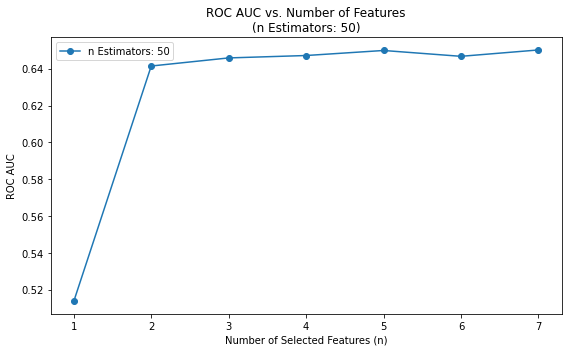

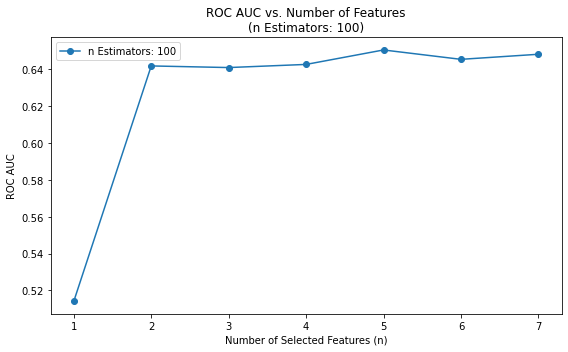

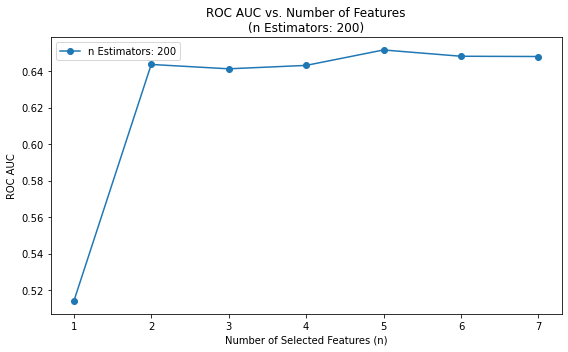

In [16]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(results, columns=["nEstimators", "nFeatures", "ROC AUC"])

# Create line plots for each n estimator
for n_estimators_value in n_estimators_values:
    plt.figure(figsize=(8, 5))
    plt.title(f"ROC AUC vs. Number of Features\n(n Estimators: {n_estimators_value})")
    plt.xlabel("Number of Selected Features (n)")
    plt.ylabel("ROC AUC")

    subset_df = results_df[(results_df["nEstimators"] == n_estimators_value)]

    plt.plot(subset_df["nFeatures"], subset_df["ROC AUC"], marker='o', linestyle='-', label=f"n Estimators: {n_estimators_value}")
    plt.legend()

    plt.tight_layout()
    plt.show()
        

The feature importance scoring built into random forest appears to be suggesting that the same four independent variables as identifed with Cramer's V are the most important predictors of Policy Issuance.

### Gradient Boosting Feature Importance Scoring

In [17]:
# Define different test sizes and n estimator values to test
test_sizes = [0.2]
n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

# Define features and target variable
features = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']
target = 'PolicyIssued'


In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import numpy as np
import pandas as pd

# Create empty lists to store results
results = []

# Define different n estimator values to test
n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

# Iterate through each n estimator value
for n_estimators_value in n_estimators_values:
    # Split the data into training and testing sets with the current test size
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])

    # Train a Gradient Boosting classifier with the current n estimator value
    gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
    gb_classifier.fit(X_train, y_train)

    # Get feature importances
    feature_importances = pd.Series(gb_classifier.feature_importances_, index=features).sort_values(ascending=False)

    # Print feature importances for the current n estimator value
    print(f"\nn_estimators: {n_estimators_value}")
    print("Feature Importances:")
    print(feature_importances)

    # Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature combination
    feature_importances_mdrauc = {}

    # Select the top-n features based on importance
    for n in n_values:
        selected_features = feature_importances[:n].index.tolist()

        # Create a new dataset with the selected features
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        gb_classifier_selected = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
        gb_classifier_selected.fit(X_train_selected, y_train)

        # Calculate ROC AUC for the entire dataset with the selected feature combination
        y_proba_selected = gb_classifier_selected.predict_proba(X_test_selected)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba_selected)

        # Append results to the dictionary
        feature_importances_mdrauc[n] = roc_auc

        # Calculate y_pred_selected for roc_auc calculation and classification report
        y_pred_selected = gb_classifier_selected.predict(X_test_selected)

        roc_auc = roc_auc_score(y_test, y_pred_selected)
        report = classification_report(y_test, y_pred_selected)
        results.append((n_estimators_value, n, roc_auc))

        # Print feature importances (MDRAUC values) for the current feature combination
        print(f"Selected Features: {selected_features}")
        print(f"ROC AUC: {roc_auc}")
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{report}")

    # Print feature importances (MDRAUC values) for the current n estimator value
    print("Feature Importances (MDRAUC):")
    print(feature_importances_mdrauc)

# Print results
print("Results:")
print(results)



n_estimators: 50
Feature Importances:
WorkflowStatus             0.732134
Agency                     0.123139
UWDecision                 0.056600
ProductGroup               0.028173
CommDateProvided           0.017467
Product                    0.012451
BonusCommission            0.010935
NoOfLives                  0.010820
ProductType                0.003844
SignedDecReceived          0.003841
Indexation                 0.000516
CommissionTerms            0.000078
PaymentFreq                0.000000
ComissionSacrifice         0.000000
CommissionSacrificeType    0.000000
RenewalSacrificeType       0.000000
Discount                   0.000000
FreeCover                  0.000000
SeriousIllnessType         0.000000
dtype: float64
Selected Features: ['WorkflowStatus']
ROC AUC: 0.5001792757260667
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      5578
           1       0.78      1.00  

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives', 'ProductType', 'SignedDecReceived', 'Indexation', 'CommissionTerms', 'PaymentFreq', 'ComissionSacrifice', 'CommissionSacrificeType']
ROC AUC: 0.5902253883282129
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.21      0.32      5578
           1       0.81      0.97      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.73      0.59      0.60     25162
weighted avg       0.78      0.80      0.76     25162

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives', 'ProductType', 'SignedDecReceived', 'Indexation', 'CommissionTerms', 'PaymentFreq', 'ComissionSacrifice', 'CommissionSacrificeType', 'RenewalSacrificeType']
ROC AUC: 0.5902253883

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives']
ROC AUC: 0.5965578017017132
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.23      0.34      5578
           1       0.81      0.96      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.73      0.60      0.61     25162
weighted avg       0.78      0.80      0.76     25162

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives', 'ProductType']
ROC AUC: 0.5965578017017132
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.23      0.34      5578
           1       0.81      0.96      0.88     19584

    accuracy                           0.80     2516


n_estimators: 200
Feature Importances:
WorkflowStatus             0.702411
Agency                     0.148086
UWDecision                 0.056156
ProductGroup               0.026817
CommDateProvided           0.017355
Product                    0.013004
BonusCommission            0.011202
NoOfLives                  0.010719
ProductType                0.004851
SignedDecReceived          0.004382
SeriousIllnessType         0.001175
Indexation                 0.001050
CommissionTerms            0.000899
CommissionSacrificeType    0.000585
ComissionSacrifice         0.000445
Discount                   0.000394
RenewalSacrificeType       0.000319
PaymentFreq                0.000151
FreeCover                  0.000000
dtype: float64
Selected Features: ['WorkflowStatus']
ROC AUC: 0.5001792757260667
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      5578
           1       0.78      1.00 

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives', 'ProductType', 'SignedDecReceived', 'SeriousIllnessType', 'Indexation', 'CommissionTerms', 'CommissionSacrificeType', 'ComissionSacrifice']
ROC AUC: 0.6097826362378345
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.26      0.37      5578
           1       0.82      0.96      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.73      0.61      0.63     25162
weighted avg       0.78      0.80      0.77     25162

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup', 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives', 'ProductType', 'SignedDecReceived', 'SeriousIllnessType', 'Indexation', 'CommissionTerms', 'CommissionSacrificeType', 'ComissionSacrifice', 'Discount']
ROC AUC: 0.60769431

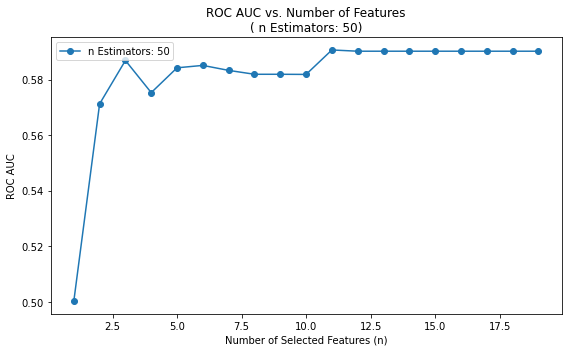

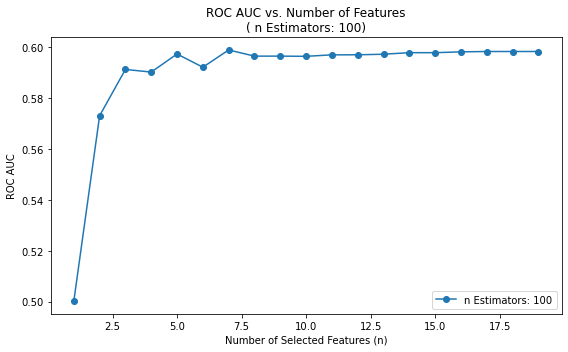

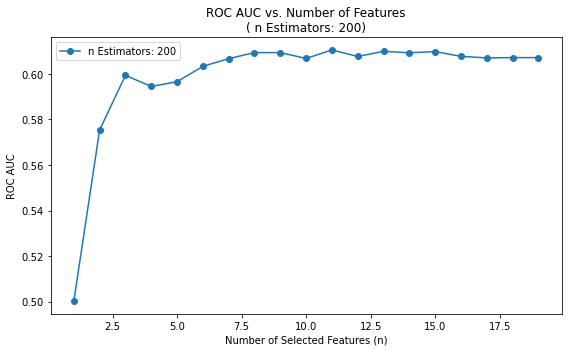

In [19]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=[ "nEstimators", "nFeatures", "ROC AUC"])

# Create line plots for each n estimator 
for n_estimators_value in n_estimators_values:
        plt.figure(figsize=(8, 5))
        plt.title(f"ROC AUC vs. Number of Features\n( n Estimators: {n_estimators_value})")
        plt.xlabel("Number of Selected Features (n)")
        plt.ylabel("ROC AUC")
        
        subset_df = results_df[(results_df["nEstimators"] == n_estimators_value)]
        
        plt.plot(subset_df["nFeatures"], subset_df["ROC AUC"], marker='o', linestyle='-', label=f"n Estimators: {n_estimators_value}")
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        

### LightGBM Feature Importance Scoring

In [20]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import pandas as pd

# Create empty lists to store results
results = []

# Define different n estimator values to test
n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

# Iterate through each n estimator value
for n_estimators_value in n_estimators_values:
    # Split the data into training and testing sets with the current test size
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])

    # Train a LightGBM classifier with the current n estimator value
    lgb_classifier = lgb.LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
    lgb_classifier.fit(X_train, y_train)

    # Get feature importances
    feature_importances = pd.Series(lgb_classifier.feature_importances_, index=features).sort_values(ascending=False)

    # Print feature importances for the current n estimator value
    print(f"\nn_estimators: {n_estimators_value}")
    print("Feature Importances:")
    print(feature_importances)

    # Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature combination
    feature_importances_mdrauc = {}

    # Select the top-n features based on importance
    for n in n_values:
        selected_features = feature_importances[:n].index.tolist()

        # Create a new dataset with the selected features
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        lgb_classifier_selected = lgb.LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
        lgb_classifier_selected.fit(X_train_selected, y_train)

        # Calculate ROC AUC for the entire dataset with the selected feature combination
        y_proba_selected = lgb_classifier_selected.predict_proba(X_test_selected)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba_selected)

        # Append results to the dictionary
        feature_importances_mdrauc[n] = roc_auc

        # Calculate y_pred_selected for roc_auc_score calculation and classification report
        y_pred_selected = lgb_classifier_selected.predict(X_test_selected)

        roc_auc = roc_auc_score(y_test, y_pred_selected)
        report = classification_report(y_test, y_pred_selected)
        results.append((n_estimators_value, n, roc_auc))

        # Print feature importances (MDRAUC values) for the current feature combination
        print(f"Selected Features: {selected_features}")
        print(f"ROC AUC: {roc_auc}")
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{report}")

    # Print feature importances (MDRAUC values) for the current n estimator value
    print("Feature Importances (MDRAUC):")
    print(feature_importances_mdrauc)

# Print results
print("Results:")
print(results)



n_estimators: 50
Feature Importances:
Agency                     963
UWDecision                  78
CommDateProvided            74
SignedDecReceived           58
ProductType                 56
WorkflowStatus              40
NoOfLives                   40
ProductGroup                34
BonusCommission             32
Product                     28
SeriousIllnessType          26
CommissionTerms             16
CommissionSacrificeType     15
ComissionSacrifice          14
Indexation                  13
Discount                     9
PaymentFreq                  2
FreeCover                    2
RenewalSacrificeType         0
dtype: int32
Selected Features: ['Agency']
ROC AUC: 0.511815601367534
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.03      0.06      5578
           1       0.78      0.99      0.88     19584

    accuracy                           0.78     25162
   macro avg       0.69      0.5

Selected Features: ['Agency', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'ProductType', 'WorkflowStatus', 'NoOfLives', 'ProductGroup', 'BonusCommission', 'Product', 'SeriousIllnessType', 'CommissionTerms', 'CommissionSacrificeType', 'ComissionSacrifice', 'Indexation']
ROC AUC: 0.6411314282943965
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.35      0.44      5578
           1       0.83      0.93      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.72      0.64      0.66     25162
weighted avg       0.78      0.80      0.78     25162

Selected Features: ['Agency', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'ProductType', 'WorkflowStatus', 'NoOfLives', 'ProductGroup', 'BonusCommission', 'Product', 'SeriousIllnessType', 'CommissionTerms', 'CommissionSacrificeType', 'ComissionSacrifice', 'Indexation', 'Discount']
ROC AUC: 0.63973523

Selected Features: ['Agency', 'ProductType', 'SignedDecReceived', 'SeriousIllnessType', 'ProductGroup', 'NoOfLives', 'UWDecision', 'CommDateProvided', 'BonusCommission']
ROC AUC: 0.6256833605469199
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.31      0.41      5578
           1       0.83      0.94      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.72      0.63      0.65     25162
weighted avg       0.78      0.80      0.78     25162

Selected Features: ['Agency', 'ProductType', 'SignedDecReceived', 'SeriousIllnessType', 'ProductGroup', 'NoOfLives', 'UWDecision', 'CommDateProvided', 'BonusCommission', 'Indexation']
ROC AUC: 0.6249673744542635
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.31      0.41      5578
           1       0.83      0.94      0.88     19

Selected Features: ['Agency']
ROC AUC: 0.5126229005406394
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.03      0.06      5578
           1       0.78      0.99      0.88     19584

    accuracy                           0.78     25162
   macro avg       0.69      0.51      0.47     25162
weighted avg       0.74      0.78      0.69     25162

Selected Features: ['Agency', 'ProductGroup']
ROC AUC: 0.5131799149084757
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.04      0.07      5578
           1       0.78      0.99      0.87     19584

    accuracy                           0.78     25162
   macro avg       0.64      0.51      0.47     25162
weighted avg       0.72      0.78      0.70     25162

Selected Features: ['Agency', 'ProductGroup', 'SeriousIllnessType']
ROC AUC: 0.5143752054201027
Accuracy: 0.78

Selected Features: ['Agency', 'ProductGroup', 'SeriousIllnessType', 'NoOfLives', 'SignedDecReceived', 'BonusCommission', 'ProductType', 'Indexation', 'CommissionTerms', 'CommDateProvided', 'UWDecision', 'ComissionSacrifice', 'Product', 'WorkflowStatus', 'CommissionSacrificeType', 'RenewalSacrificeType']
ROC AUC: 0.6446282203720499
Accuracy: 0.7805818297432636
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      5578
           1       0.84      0.92      0.88     19584

    accuracy                           0.80     25162
   macro avg       0.71      0.64      0.66     25162
weighted avg       0.78      0.80      0.78     25162

Selected Features: ['Agency', 'ProductGroup', 'SeriousIllnessType', 'NoOfLives', 'SignedDecReceived', 'BonusCommission', 'ProductType', 'Indexation', 'CommissionTerms', 'CommDateProvided', 'UWDecision', 'ComissionSacrifice', 'Product', 'WorkflowStatus', 'CommissionSacrificeType', 'Renewa

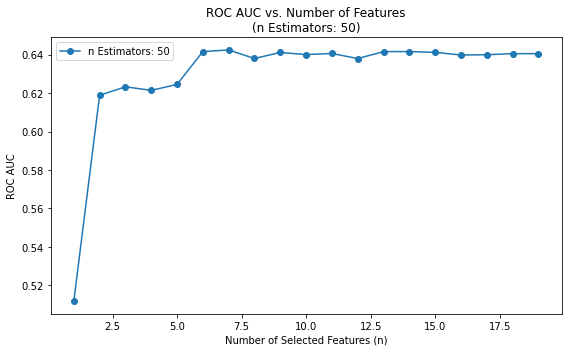

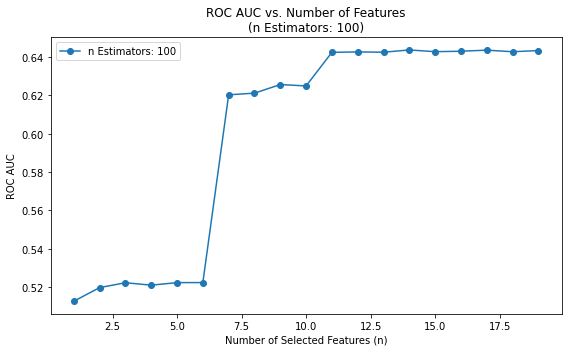

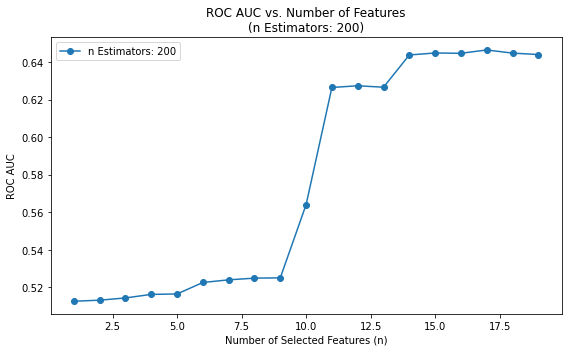

In [21]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=["nEstimators", "nFeatures", "ROC AUC"])

# Create line plots for each n estimator
for n_estimators_value in n_estimators_values:
    plt.figure(figsize=(8, 5))
    plt.title(f"ROC AUC vs. Number of Features\n(n Estimators: {n_estimators_value})")
    plt.xlabel("Number of Selected Features (n)")
    plt.ylabel("ROC AUC")

    subset_df = results_df[(results_df["nEstimators"] == n_estimators_value)]

    plt.plot(subset_df["nFeatures"], subset_df["ROC AUC"], marker='o', linestyle='-', label=f"n Estimators: {n_estimators_value}")
    plt.legend()

    plt.tight_layout()
    plt.show()


### Class Aware Feature Importance

In [22]:
df = df.drop(columns=['PropDate'])

# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd

# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Calculate feature importance scores
feature_importance = rf_classifier.feature_importances_

# Calculate class-specific importance
class_labels = df['PolicyIssued'].unique()
class_importance = {}
for label in class_labels:
    mask = (y_train == label)
    class_importance[label] = feature_importance * mask.mean()

# Calculate ROC AUC for the entire dataset
y_proba = rf_classifier.predict_proba(X_test)[:, 1]
roc_auc_all = roc_auc_score(y_test, y_proba)

# Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature
feature_importances_mdrauc = {}

# Iterate through each feature to calculate MDRAUC
for feature_name in X.columns:
    # Create a dataset with the current feature
    X_feature = X_test.copy()
    X_feature[feature_name] = np.random.permutation(X_feature[feature_name])

    # Calculate ROC AUC for the dataset with the permuted feature
    y_proba_permuted = rf_classifier.predict_proba(X_feature)[:, 1]
    roc_auc_permuted = roc_auc_score(y_test, y_proba_permuted)

    # Calculate MDRAUC for the current feature
    mdrauc = roc_auc_all - roc_auc_permuted
    feature_importances_mdrauc[feature_name] = mdrauc

# Print the MDRAUC scores for each feature in descending order
importance_scores_sorted = sorted(feature_importances_mdrauc.items(), key=lambda x: x[1], reverse=True)

for feature_name, mdrauc in importance_scores_sorted:
    print(f"Feature: {feature_name}, MDRAUC: {mdrauc:.4f}")


Feature: WorkflowStatus, MDRAUC: 0.1325
Feature: Agency, MDRAUC: 0.0302
Feature: UWDecision, MDRAUC: 0.0215
Feature: CommDateProvided, MDRAUC: 0.0118
Feature: SignedDecReceived, MDRAUC: 0.0077
Feature: NoOfLives, MDRAUC: 0.0037
Feature: CommissionTerms, MDRAUC: 0.0034
Feature: SeriousIllnessType, MDRAUC: 0.0015
Feature: PaymentFreq, MDRAUC: 0.0002
Feature: Indexation, MDRAUC: 0.0002
Feature: FreeCover, MDRAUC: -0.0000
Feature: Discount, MDRAUC: -0.0005
Feature: RenewalSacrificeType, MDRAUC: -0.0005
Feature: BonusCommissionPercentage, MDRAUC: -0.0005
Feature: CommissionSacrificePercentage, MDRAUC: -0.0006
Feature: ProductType, MDRAUC: -0.0021
Feature: CommissionSacrificeType, MDRAUC: -0.0026
Feature: BonusCommission, MDRAUC: -0.0035
Feature: ComissionSacrifice, MDRAUC: -0.0041
Feature: ProductGroup, MDRAUC: -0.0062
Feature: Product, MDRAUC: -0.0097


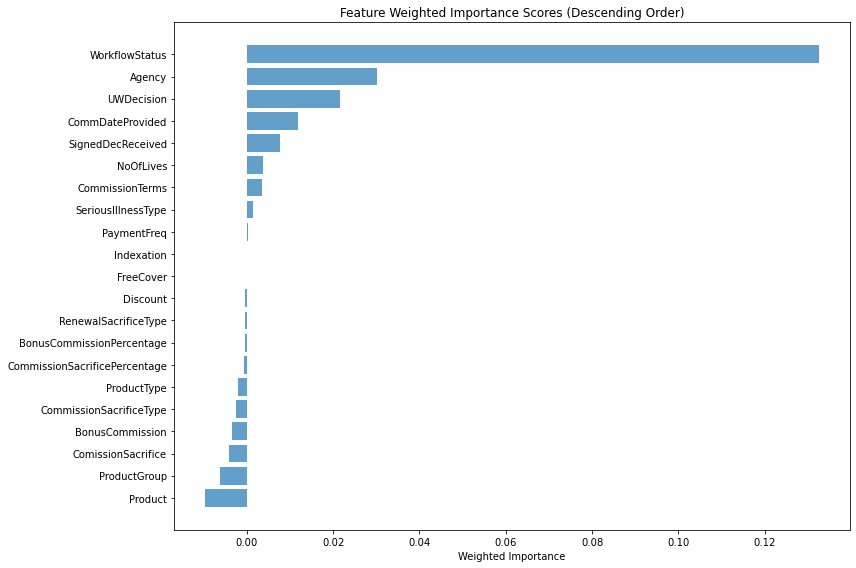

In [24]:
# Extract feature names and importance scores
feature_names, importance_scores = zip(*importance_scores_sorted)

# Create a bar plot to visualise the weighted importance scores
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names)), importance_scores, align='center', alpha=0.7)
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Weighted Importance')
plt.title('Feature Weighted Importance Scores (Descending Order)')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.tight_layout()
plt.show()

### Recursive Feature Elimination with Cross-Validation

#### Random Forest

In [25]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a RandomForestClassifier on the scaled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

# Fit RFECV on the scaled data
rfecv.fit(X_train, y_train)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)


Selected features:
Agency
WorkflowStatus


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


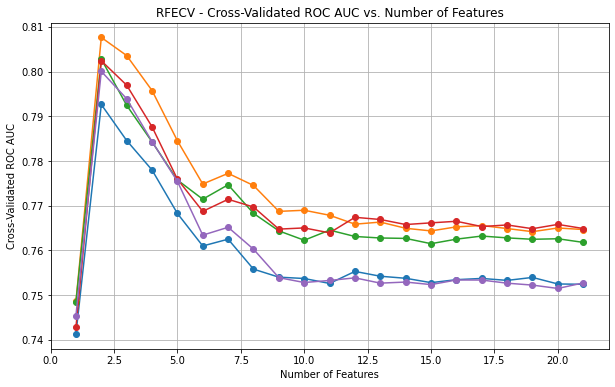

In [26]:
# Plot the cross-validated roc auc vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated ROC AUC vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated ROC AUC")
plt.grid(True)

# Plot the curve of cross-validated roc auc
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()


#### GradientBoostingClassifier

In [27]:
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=gb_classifier, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

# Fit RFECV on the resampled data
rfecv.fit(X_train, y_train)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)
    

Selected features:
Product
ProductGroup
ProductType
Agency
WorkflowStatus
NoOfLives
CommDateProvided
UWDecision
BonusCommission
BonusCommissionPercentage
SignedDecReceived


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


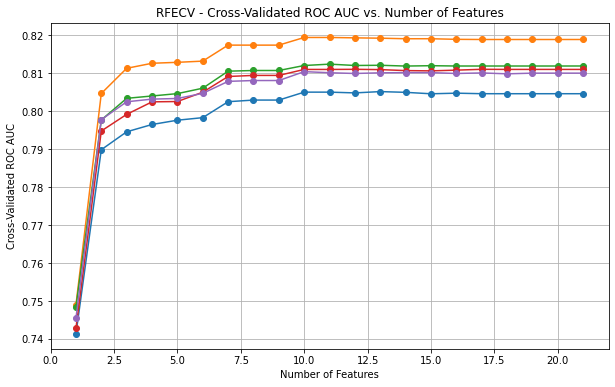

In [28]:
# Plot the cross-validated roc_auc vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated ROC AUC vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated ROC AUC")
plt.grid(True)

# Plot the curve of cross-validated roc_auc
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()


#### LightGBM

In [29]:
lgb_classifier = lgb.LGBMClassifier(random_state=42)
lgb_classifier.fit(X_train, y_train)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=lgb_classifier, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

# Fit RFECV on the resampled data
rfecv.fit(X_train, y_train)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)
    

Selected features:
Product
Agency
WorkflowStatus
CommDateProvided
UWDecision
CommissionSacrificePercentage
CommissionTerms
BonusCommissionPercentage
SignedDecReceived


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


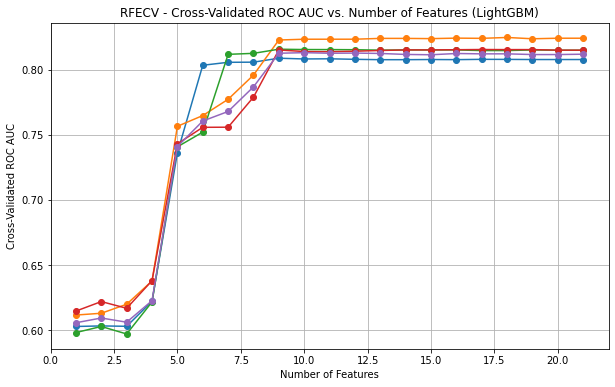

In [30]:
# Plot the cross-validated roc_auc vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated ROC AUC vs. Number of Features (LightGBM)")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated ROC AUC")
plt.grid(True)

# Plot the curve of cross-validated roc_auc
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()


## Rebalancing imbalanced target variable - Oversampling

### Random Forest Feature Importance Scoring

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE

# Create empty lists to store results
results = []

# Define different n estimator values to test
n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Iterate through each n estimator value
for n_estimators_value in n_estimators_values:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scaling features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resampling with BorderlineSMOTE
    smote = BorderlineSMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    # Convert X_train_resampled and X_test back to Pandas DataFrames
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    X_test = pd.DataFrame(X_test, columns=X_train.columns)

    # Train a Random Forest classifier with the current n estimator value
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
    rf_classifier.fit(X_train_resampled, y_train_resampled)

    # Get feature importances
    feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_train_resampled.columns).sort_values(ascending=False)

    # Print feature importances for the current n estimator value
    print(f"\n n_estimators: {n_estimators_value}")
    print("Feature Importances:")
    print(feature_importances)

    # Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature combination
    feature_importances_mdrauc = {}

    # Select the top-n features based on importance
    for n in n_values:
        selected_features = feature_importances.index[:n].tolist()

        # Create a new dataset with the selected features
        X_train_selected = X_train_resampled[selected_features]
        X_test_selected = X_test[selected_features]

        rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier_selected.fit(X_train_selected, y_train_resampled)

        # Calculate ROC AUC for the entire dataset with the selected feature combination
        y_proba_selected = rf_classifier_selected.predict_proba(X_test_selected)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba_selected)

        # Append results to the dictionary
        feature_importances_mdrauc[n] = roc_auc

        # Calculate y_pred_selected for roc_auc calculation and classification report
        y_pred_selected = rf_classifier_selected.predict(X_test_selected)

        roc_auc = roc_auc_score(y_test, y_pred_selected)
        report = classification_report(y_test, y_pred_selected)
        results.append((n_estimators_value, n, selected_features, roc_auc, report))

        # Print feature importances (MDRAUC values) for the current feature combination
        print("Selected Features:", selected_features)
        print("ROC AUC:", roc_auc)
        print("Classification Report:")
        print(report)

    # Print feature importances (MDRAUC values) for the current n estimator value
    print("Feature Importances (MDRAUC):")
    print(feature_importances_mdrauc)

# Print results
print("\nResults:")
for result in results:
    n_estimators_value, n, selected_features, roc_auc, report = result
    print(f"n_estimators: {n_estimators_value}")
    print("Selected Features:", selected_features)
    print(f"ROC AUC: {roc_auc}")
    print("Classification Report:")
    print(report)



 n_estimators: 50
Feature Importances:
Agency                           0.427256
WorkflowStatus                   0.239154
BonusCommissionPercentage        0.068366
UWDecision                       0.061990
CommDateProvided                 0.057668
CommissionSacrificePercentage    0.057188
SignedDecReceived                0.018066
NoOfLives                        0.014510
CommissionTerms                  0.008953
SeriousIllnessType               0.008596
Indexation                       0.008116
Product                          0.007305
ProductGroup                     0.005150
BonusCommission                  0.003740
RenewalSacrificeType             0.002600
CommissionSacrificeType          0.002390
Discount                         0.002129
ProductType                      0.002042
ComissionSacrifice               0.001942
PaymentFreq                      0.001580
FreeCover                        0.001261
dtype: float64


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus']
ROC AUC: 0.5000765931372549
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       1.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.61      0.50      0.18     25162
weighted avg       0.83      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage']
ROC AUC: 0.5001021241830066
Classification Report:
              precision    recall  f1-score   support

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommDateProvided', 'CommissionSacrificePercentage', 'SignedDecReceived']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommDateProvided', 'CommissionSacrificePercentage', 'SignedDecReceived', 'NoOfLives']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommDateProvided', 'CommissionSacrificePercentage', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms']
ROC AUC: 0.5000124863199732
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.80      0.00      0.00     19584

    accuracy                           0.22    

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommDateProvided', 'CommissionSacrificePercentage', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommDateProvided', 'CommissionSacrificePercentage', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission', 'RenewalSacrificeType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommDateProvided', 'CommissionSacrificePercentage', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission', 'RenewalSacrificeType', 'CommissionSacrificeType']
ROC 

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommDateProvided', 'CommissionSacrificePercentage', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission', 'RenewalSacrificeType', 'CommissionSacrificeType', 'Discount', 'ProductType', 'ComissionSacrifice']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Feature Importances (MDRAUC):
{1: 0.5000124863199732, 2: 0.2562372189149952, 3: 0.6215364696845332, 4: 0.6038338568067361, 5: 0.4665445259240902, 6: 0.5977670432042783, 7: 0.5726589257707684, 8: 0.6840746380944513, 9: 0.535574463908457, 10: 0.521641753895146

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus']
ROC AUC: 0.5000765931372549
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       1.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.61      0.50      0.18     25162
weighted avg       0.83      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage']
ROC AUC: 0.5001021241830066
Classification Report:
              precision    recall  f1-score   support

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives']
ROC AUC: 0.5000510620915033
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       1.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.61  

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission', 'RenewalSacrificeType']
ROC AUC: 0.5000510620915033
Classification Report:
    

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission', 'RenewalSacrificeType', 'CommissionSacrificeType', 'Discount', 'ProductType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus', 'BonusCommissionPercentage', 'UWDecision', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission', '

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus']
ROC AUC: 0.5000765931372549
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       1.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.61      0.50      0.18     25162
weighted avg       0.83      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision']
ROC AUC: 0.5000124863199732
Classification Report:
              precision    recall  f1-score   support

           0 

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'BonusCommissionPercentage', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'BonusCommissionPercentage', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'BonusCommissionPercentage', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission', 'RenewalSacrificeType']
ROC AUC: 0.5000510620915033
Classification Report:
    

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'BonusCommissionPercentage', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission', 'RenewalSacrificeType', 'CommissionSacrificeType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'BonusCommissionPercentage', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission', 'RenewalSacrificeType', 'Com

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'BonusCommissionPercentage', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommission', 'RenewalSacrificeType', 'CommissionSacrificeType', 'Discount', 'ComissionSacrifice']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'BonusCommissionPercentage', 'CommissionSacrificePercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'CommissionTerms', 'SeriousIllnessType', 'Indexation', 'Product', 'ProductGroup', 'BonusCommiss

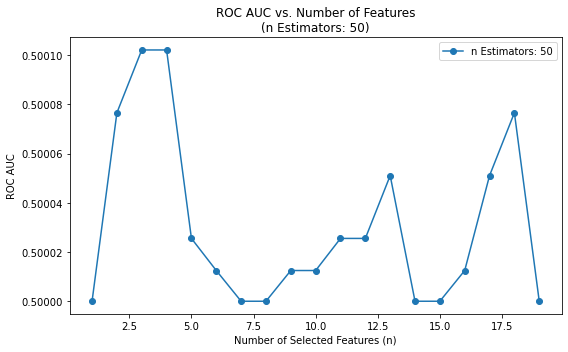

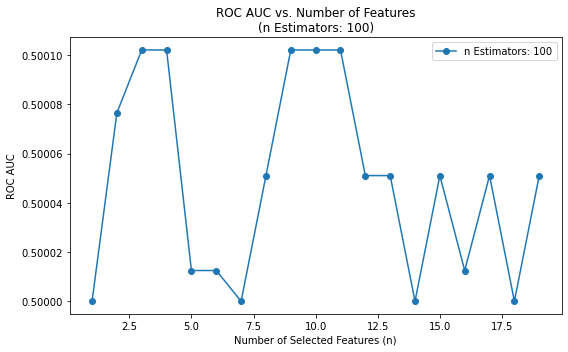

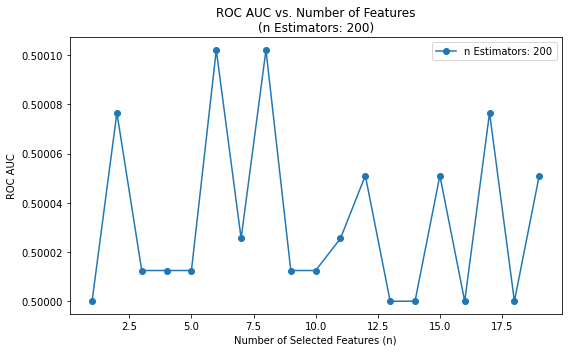

In [23]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(results, columns=["n_estimators_value", "n", "selected_features", "roc_auc", "report"])

# Create line plots for each n estimator
for n_estimators_value in n_estimators_values:
    plt.figure(figsize=(8, 5))
    plt.title(f"ROC AUC vs. Number of Features\n(n Estimators: {n_estimators_value})")
    plt.xlabel("Number of Selected Features (n)")
    plt.ylabel("ROC AUC")

    subset_df = results_df[(results_df["n_estimators_value"] == n_estimators_value)]

    plt.plot(subset_df["n"], subset_df["roc_auc"], marker='o', linestyle='-', label=f"n Estimators: {n_estimators_value}")
    plt.legend()

    plt.tight_layout()
    plt.show()


### Gradient Boosting Classifier Feature Importance Scoring

In [14]:
# Create empty lists to store results
results = []

# Define different n estimator values to test
n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Iterate through each n estimator value
for n_estimators_value in n_estimators_values:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scaling features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resampling with BorderlineSMOTE
    smote = BorderlineSMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    # Convert X_train_resampled and X_test back to Pandas DataFrames
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    X_test = pd.DataFrame(X_test, columns=X_train.columns)

    # Train a Random Forest classifier with the current n estimator value
    gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
    gb_classifier.fit(X_train_resampled, y_train_resampled)

    # Get feature importances
    feature_importances = pd.Series(gb_classifier.feature_importances_, index=X_train_resampled.columns).sort_values(ascending=False)

    # Print feature importances for the current n estimator value
    print(f"\n n_estimators: {n_estimators_value}")
    print("Feature Importances:")
    print(feature_importances)

    # Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature combination
    feature_importances_mdrauc = {}

    # Select the top-n features based on importance
    for n in n_values:
        selected_features = feature_importances.index[:n].tolist()

        # Create a new dataset with the selected features
        X_train_selected = X_train_resampled[selected_features]
        X_test_selected = X_test[selected_features]

        gb_classifier_selected = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
        gb_classifier_selected.fit(X_train_selected, y_train_resampled)

        # Calculate ROC AUC for the entire dataset with the selected feature combination
        y_proba_selected = gb_classifier_selected.predict_proba(X_test_selected)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba_selected)

        # Append results to the dictionary
        feature_importances_mdrauc[n] = roc_auc

        # Calculate y_pred_selected for roc_auc calculation and classification report
        y_pred_selected = gb_classifier_selected.predict(X_test_selected)

        roc_auc = roc_auc_score(y_test, y_pred_selected)
        report = classification_report(y_test, y_pred_selected)
        results.append((n_estimators_value, n, selected_features, roc_auc, report))

        # Print feature importances (MDRAUC values) for the current feature combination
        print("Selected Features:", selected_features)
        print("ROC AUC:", roc_auc)
        print("Classification Report:")
        print(report)

    # Print feature importances (MDRAUC values) for the current n estimator value
    print("Feature Importances (MDRAUC):")
    print(feature_importances_mdrauc)

# Print results
print("\nResults:")
for result in results:
    n_estimators_value, n, selected_features, roc_auc, report = result
    print(f"n_estimators: {n_estimators_value}")
    print("Selected Features:", selected_features)
    print(f"ROC AUC: {roc_auc}")
    print("Classification Report:")
    print(report)




 n_estimators: 50
Feature Importances:
WorkflowStatus                   0.851460
UWDecision                       0.047175
CommDateProvided                 0.029293
Agency                           0.025378
SignedDecReceived                0.021661
BonusCommissionPercentage        0.009086
ProductGroup                     0.006151
NoOfLives                        0.005301
BonusCommission                  0.001152
ProductType                      0.000920
CommissionTerms                  0.000811
ComissionSacrifice               0.000774
Product                          0.000597
CommissionSacrificePercentage    0.000224
CommissionSacrificeType          0.000016
RenewalSacrificeType             0.000000
Discount                         0.000000
PaymentFreq                      0.000000
Indexation                       0.000000
FreeCover                        0.000000
SeriousIllnessType               0.000000
dtype: float64
Selected Features: ['WorkflowStatus']
ROC AUC: 0.74397043481101

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives', 'BonusCommission']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives', 'BonusCommission', 'ProductType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives', 'BonusCommission', 'ProductType', 'CommissionTerms']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives', 'BonusCommission', 'ProductType', 'CommissionTerms', 'ComissionSacrifice']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives', 'BonusCommission', 'ProductType', 'CommissionTerms', 'ComissionSacrifice', 'Product']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives', 'BonusCommission', 'ProductType', 'CommissionTerms', 'ComissionSacrifice', 'Product', 'CommissionSacrificePercentage']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives', 'BonusCommission', 'ProductType', 'CommissionTerms', 'ComissionSacrifice', 'Product', 'CommissionSacrificePercentage', 'CommissionSacrificeType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives', 'BonusCommission', 'ProductType', 'CommissionTerms', 'ComissionSacrifice', 'Product', 'CommissionSacrificePercentage', 'CommissionSacrificeType', 'RenewalSacrificeType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives', 'BonusCommission', 'ProductType', 'CommissionTerms', 'ComissionSacrifice', 'Product', 'CommissionSacrificePercentage', 'CommissionSacrificeType', 'RenewalSacrificeType', 'Discount']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives', 'BonusCommission', 'ProductType', 'CommissionTerms', 'ComissionSacrifice', 'Product', 'CommissionSacrificePercentage', 'CommissionSacrificeType', 'RenewalSacrificeType', 'Discount', 'PaymentFreq']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'CommDateProvided', 'Agency', 'SignedDecReceived', 'BonusCommissionPercentage', 'ProductGroup', 'NoOfLives', 'BonusCommission', 'ProductType', 'CommissionTerms', 'ComissionSacrifice', 'Product', 'CommissionSacrificePercentage', 'CommissionSacrificeType', 'RenewalSacrificeType', 'Discount', 'PaymentFreq', 'Indexation']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Feature Importances (MDRAUC):
{1: 0.7439704348110106, 2: 0.7614566379766918, 3: 0.5, 4: 0.24919474678914835, 5: 0.24951505202071866, 6: 0.32320943150700593, 7: 0.24652649619068373, 8: 0.24628527861410493, 9: 0.24628527861410493, 10: 0.2535317107488687, 11: 0.397311

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'CommissionTerms']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'CommissionTerms', 'ProductType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'CommissionTerms', 'ProductType', 'ComissionSacrifice']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'CommissionTerms', 'ProductType', 'ComissionSacrifice', 'BonusCommission']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'CommissionTerms', 'ProductType', 'ComissionSacrifice', 'BonusCommission', 'Product']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'CommissionTerms', 'ProductType', 'ComissionSacrifice', 'BonusCommission', 'Product', 'Discount']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'CommissionTerms', 'ProductType', 'ComissionSacrifice', 'BonusCommission', 'Product', 'Discount', 'RenewalSacrificeType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'CommissionTerms', 'ProductType', 'ComissionSacrifice', 'BonusCommission', 'Product', 'Discount', 'RenewalSacrificeType', 'SeriousIllnessType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'CommissionTerms', 'ProductType', 'ComissionSacrifice', 'BonusCommission', 'Product', 'Discount', 'RenewalSacrificeType', 'SeriousIllnessType', 'Indexation']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'UWDecision', 'Agency', 'CommDateProvided', 'BonusCommissionPercentage', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'CommissionTerms', 'ProductType', 'ComissionSacrifice', 'BonusCommission', 'Product', 'Discount', 'RenewalSacrificeType', 'SeriousIllnessType', 'Indexation', 'CommissionSacrificeType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Feature Importances (MDRAUC):
{1: 0.7439704348110106, 2: 0.7667062384144527, 3: 0.7438641866638195, 4: 0.24919474678914835, 5: 0.2553427947049801, 6: 0.24704260046764015, 7: 0.32404214272134696, 8: 0.3235044070850822, 9: 0.3404724050863922, 10: 0.34227352470

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation', 'RenewalSacrificeType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation', 'RenewalSacrificeType', 'Discount']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'B

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


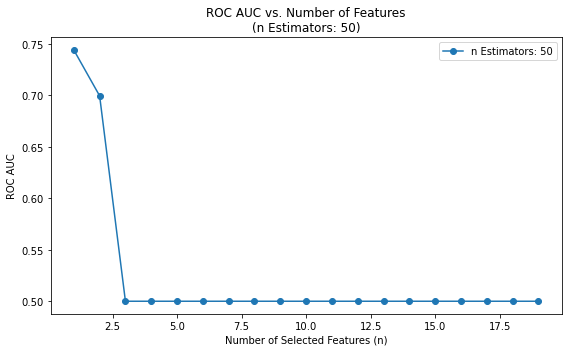

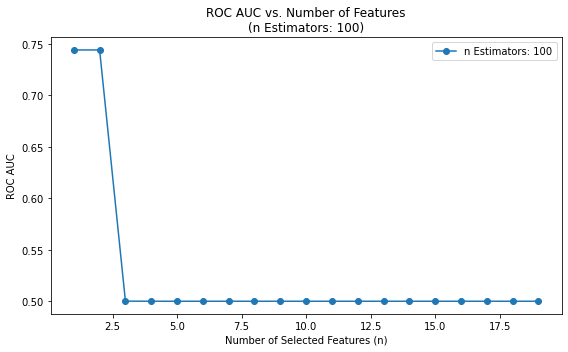

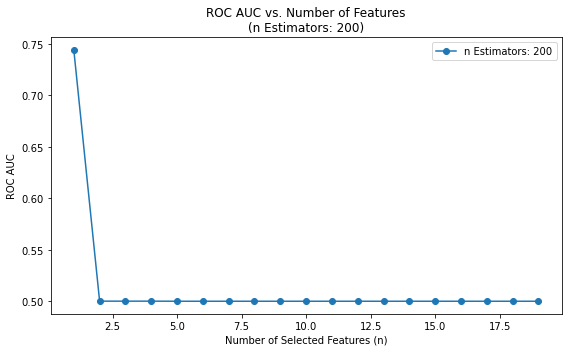

In [17]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(results, columns=["n_estimators_value", "n", "selected_features", "roc_auc", "report"])

# Create line plots for each n estimator
for n_estimators_value in n_estimators_values:
    plt.figure(figsize=(8, 5))
    plt.title(f"ROC AUC vs. Number of Features\n(n Estimators: {n_estimators_value})")
    plt.xlabel("Number of Selected Features (n)")
    plt.ylabel("ROC AUC")

    subset_df = results_df[(results_df["n_estimators_value"] == n_estimators_value)]

    plt.plot(subset_df["n"], subset_df["roc_auc"], marker='o', linestyle='-', label=f"n Estimators: {n_estimators_value}")
    plt.legend()

    plt.tight_layout()
    plt.show()


### Light GBM Feature Importance Scoring

In [26]:
# Define categorical columns
categorical_columns = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']

# Convert categorical columns to categorical data types
df[categorical_columns] = df[categorical_columns].astype('category')

# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Create empty lists to store results
results = []

# Define different n estimator values to test
n_estimators_values = [50, 100, 200]
n_values = list(range(1, 20))

# Iterate through each n estimator value
for n_estimators_value in n_estimators_values:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scaling features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resampling with BorderlineSMOTE
    smote = BorderlineSMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    # Convert X_train_resampled and X_test back to Pandas DataFrames
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    X_test = pd.DataFrame(X_test, columns=X_train.columns)
    
    # Reapply categorical transformation to resampled datasets
    X_train_resampled[categorical_columns] = X_train_resampled[categorical_columns].astype('category')
    X_test[categorical_columns] = X_test[categorical_columns].astype('category')

    # Train a Random Forest classifier with the current n estimator value
    lgb_classifier = LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
    lgb_classifier.fit(X_train_resampled, y_train_resampled)

    # Get feature importances
    feature_importances = pd.Series(gb_classifier.feature_importances_, index=X_train_resampled.columns).sort_values(ascending=False)

    # Print feature importances for the current n estimator value
    print(f"\n n_estimators: {n_estimators_value}")
    print("Feature Importances:")
    print(feature_importances)

    # Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature combination
    feature_importances_mdrauc = {}

    # Select the top-n features based on importance
    for n in n_values:
        selected_features = feature_importances.index[:n].tolist()

        # Create a new dataset with the selected features
        X_train_selected = X_train_resampled[selected_features]
        X_test_selected = X_test[selected_features]

        lgb_classifier_selected = LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
        lgb_classifier_selected.fit(X_train_selected, y_train_resampled)

        # Calculate ROC AUC for the entire dataset with the selected feature combination
        y_proba_selected = lgb_classifier_selected.predict_proba(X_test_selected)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba_selected)

        # Append results to the dictionary
        feature_importances_mdrauc[n] = roc_auc

        # Calculate y_pred_selected for roc_auc calculation and classification report
        y_pred_selected = lgb_classifier_selected.predict(X_test_selected)

        roc_auc = roc_auc_score(y_test, y_pred_selected)
        report = classification_report(y_test, y_pred_selected)
        results.append((n_estimators_value, n, selected_features, roc_auc, report))

        # Print feature importances (MDRAUC values) for the current feature combination
        print("Selected Features:", selected_features)
        print("ROC AUC:", roc_auc)
        print("Classification Report:")
        print(report)

    # Print feature importances (MDRAUC values) for the current n estimator value
    print("Feature Importances (MDRAUC):")
    print(feature_importances_mdrauc)

# Print results
print("\nResults:")
for result in results:
    n_estimators_value, n, selected_features, roc_auc, report = result
    print(f"n_estimators: {n_estimators_value}")
    print("Selected Features:", selected_features)
    print(f"ROC AUC: {roc_auc}")
    print("Classification Report:")
    print(report)



 n_estimators: 50
Feature Importances:
WorkflowStatus                   0.787252
Agency                           0.050419
UWDecision                       0.045035
BonusCommissionPercentage        0.036314
CommDateProvided                 0.028415
SignedDecReceived                0.022056
NoOfLives                        0.007569
ProductGroup                     0.006296
CommissionSacrificePercentage    0.003787
Product                          0.002598
CommissionTerms                  0.002274
SeriousIllnessType               0.001983
ComissionSacrifice               0.001532
ProductType                      0.001488
BonusCommission                  0.001179
Indexation                       0.000574
RenewalSacrificeType             0.000537
Discount                         0.000525
PaymentFreq                      0.000152
CommissionSacrificeType          0.000015
FreeCover                        0.000000
dtype: float64


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation', 'RenewalSacrificeType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation', 'RenewalSacrificeType', 'Discount']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation', 'RenewalSacrificeType', 'Discount', 'PaymentFreq']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Feature Importances (MDRAUC):
{1: 0.5, 2: 0.5, 3: 0.5, 4: 0.4989822367634755, 5: 0.4999821401684254, 6: 0.5003938042514124, 7: 0.5003938042514124, 8: 0.49995094725397626, 9: 0.5003028207219304, 10: 0.5, 11: 0.5003031685812844, 12: 0.5003031685812844, 13: 0.5000662168588

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation', 'RenewalSacrificeType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation', 'RenewalSacrificeType', 'Discount']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation', 'RenewalSacrificeType', 'Discount', 'PaymentFreq']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Feature Importances (MDRAUC):
{1: 0.5, 2: 0.5, 3: 0.5, 4: 0.49991685703727534, 5: 0.49991870618436807, 6: 0.49989467642635516, 7: 0.5000886309017452, 8: 0.5000106005561062, 9: 0.5087426255647771, 10: 0.5087174194928958, 11: 0.5086219275231008, 12: 0.5145386581226551, 13

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation', 'RenewalSacrificeType']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162



C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'BonusCommission', 'Indexation', 'RenewalSacrificeType', 'Discount']
ROC AUC: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      5578
           1       0.00      0.00      0.00     19584

    accuracy                           0.22     25162
   macro avg       0.11      0.50      0.18     25162
weighted avg       0.05      0.22      0.08     25162

Selected Features: ['WorkflowStatus', 'Agency', 'UWDecision', 'BonusCommissionPercentage', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup', 'CommissionSacrificePercentage', 'Product', 'CommissionTerms', 'SeriousIllnessType', 'ComissionSacrifice', 'ProductType', 'B

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


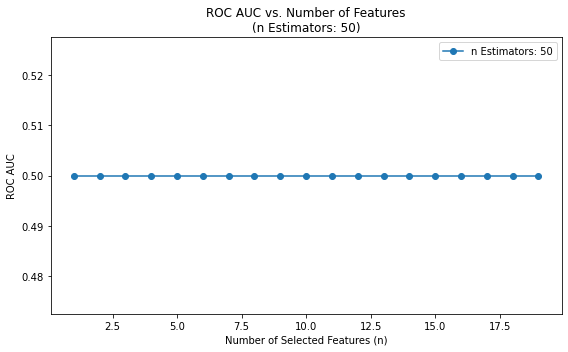

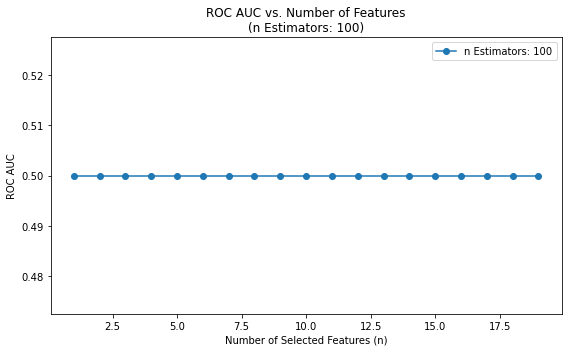

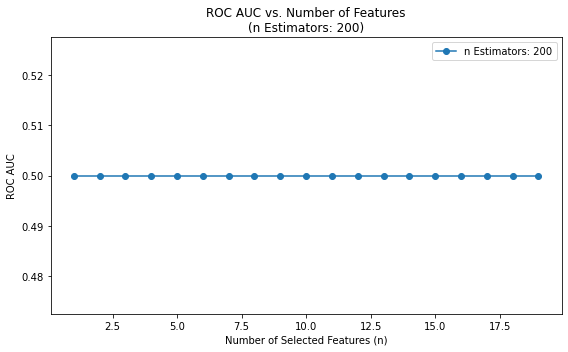

In [27]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(results, columns=["n_estimators_value", "n", "selected_features", "roc_auc", "report"])

# Create line plots for each n estimator
for n_estimators_value in n_estimators_values:
    plt.figure(figsize=(8, 5))
    plt.title(f"ROC AUC vs. Number of Features\n(n Estimators: {n_estimators_value})")
    plt.xlabel("Number of Selected Features (n)")
    plt.ylabel("ROC AUC")

    subset_df = results_df[(results_df["n_estimators_value"] == n_estimators_value)]

    plt.plot(subset_df["n"], subset_df["roc_auc"], marker='o', linestyle='-', label=f"n Estimators: {n_estimators_value}")
    plt.legend()

    plt.tight_layout()
    plt.show()


#### Class Aware Feature Importance

In [32]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']


In [33]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


Scaler and Borderline SMOTE used in order to avoid the introduction of unrealistic sythetic data points

In [34]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [35]:
# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd

# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Calculate feature importance scores
feature_importance = rf_classifier.feature_importances_

# Calculate class-specific importance
class_labels = df['PolicyIssued'].unique()
class_importance = {}
for label in class_labels:
    mask = (y_train_resampled == label)
    class_importance[label] = feature_importance * mask.mean()

# Calculate ROC AUC for the entire dataset
y_proba = rf_classifier.predict_proba(X_test)[:, 1]
roc_auc_all = roc_auc_score(y_test, y_proba)

# Initialise an empty dictionary to store feature importances (MDRAUC values) for each feature
feature_importances_mdrauc = {}

# Iterate through each feature to calculate MDRAUC
for feature_name in X.columns:
    # Create a dataset with the current feature
    X_feature = X_test.copy()
    X_feature[feature_name] = np.random.permutation(X_feature[feature_name])

    # Calculate ROC AUC for the dataset with the permuted feature
    y_proba_permuted = rf_classifier.predict_proba(X_feature)[:, 1]
    roc_auc_permuted = roc_auc_score(y_test, y_proba_permuted)

    # Calculate MDRAUC for the current feature
    mdrauc = roc_auc_all - roc_auc_permuted
    feature_importances_mdrauc[feature_name] = mdrauc

# Print the MDRAUC scores for each feature in descending order
importance_scores_sorted = sorted(feature_importances_mdrauc.items(), key=lambda x: x[1], reverse=True)

for feature_name, mdrauc in importance_scores_sorted:
    print(f"Feature: {feature_name}, MDRAUC: {mdrauc:.4f}")


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier 

Feature: CommDateProvided, MDRAUC: 0.0382
Feature: WorkflowStatus, MDRAUC: 0.0329
Feature: SignedDecReceived, MDRAUC: 0.0253
Feature: CommissionSacrificePercentage, MDRAUC: 0.0093
Feature: BonusCommissionPercentage, MDRAUC: 0.0039
Feature: BonusCommission, MDRAUC: 0.0032
Feature: Indexation, MDRAUC: 0.0022
Feature: ComissionSacrifice, MDRAUC: 0.0017
Feature: Agency, MDRAUC: 0.0000
Feature: Product, MDRAUC: 0.0000
Feature: CommissionSacrificeType, MDRAUC: 0.0000
Feature: ProductGroup, MDRAUC: 0.0000
Feature: NoOfLives, MDRAUC: 0.0000
Feature: PaymentFreq, MDRAUC: 0.0000
Feature: Discount, MDRAUC: 0.0000
Feature: FreeCover, MDRAUC: 0.0000
Feature: SeriousIllnessType, MDRAUC: -0.0001
Feature: RenewalSacrificeType, MDRAUC: -0.0004
Feature: CommissionTerms, MDRAUC: -0.0006
Feature: ProductType, MDRAUC: -0.0016
Feature: UWDecision, MDRAUC: -0.0513


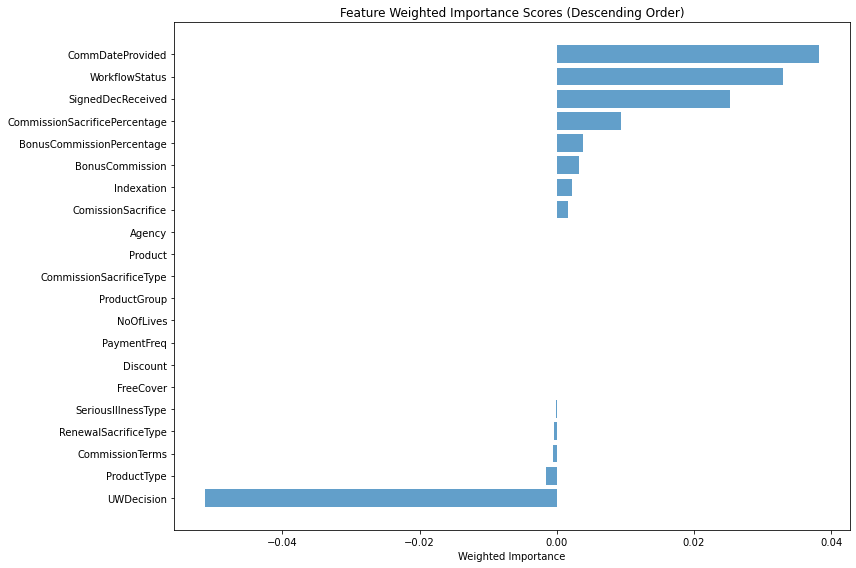

In [37]:
# Extract feature names and importance scores
feature_names, importance_scores = zip(*importance_scores_sorted)

# Create a bar plot to visualize the weighted importance scores
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names)), importance_scores, align='center', alpha=0.7)
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Weighted Importance')
plt.title('Feature Weighted Importance Scores (Descending Order)')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.tight_layout()
plt.show()

### Recursive Feature Elimination with Cross-Validation

#### Random Forest

In [38]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)


Selected features:
Agency
WorkflowStatus


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


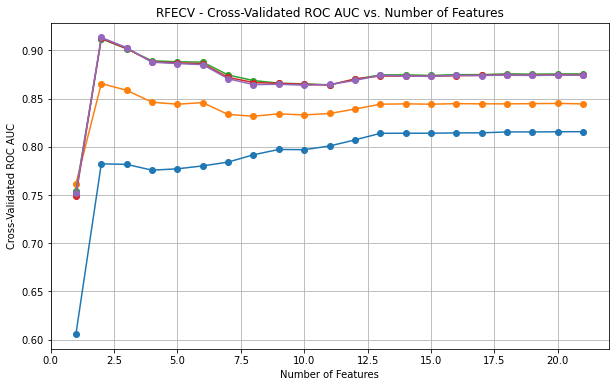

In [39]:
# Plot the cross-validated roc_auc vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated ROC AUC vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated ROC AUC")
plt.grid(True)

# Plot the curve of cross-validated roc_auc
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()

The result "Selected features: Agency, WorkflowStatus" indicates that the algorithm determined that the two features "Agency" and "WorkflowStatus" are the most important features for predicting the target variable ("PolicyIssued") after applying Recursive Feature Elimination with Cross-Validation (RFECV) on the resampled dataset.

Agency is expected to have a significant predictive value in deciding whether or not a policy will be issued. It implies that the agency linked with the application has a significant impact on the conversion of life assurance applications.

WorkflowStatus element is also crucial in predicting the outcome.

The fact that just these two features were chosen shows that the other features did not contribute as much to the prediction of the target variable, according to the RFECV algorithm. This might imply that these two features include the most essential information for predicting policy issuance.

#### GradientBoostingClassifier

In [41]:
gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
    
# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=gb_classifier, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)
    

Selected features:
Product
ProductGroup
ProductType
Agency
WorkflowStatus
Indexation
NoOfLives
CommDateProvided
UWDecision
ComissionSacrifice
CommissionSacrificePercentage
CommissionTerms
BonusCommissionPercentage
SeriousIllnessType
SignedDecReceived


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


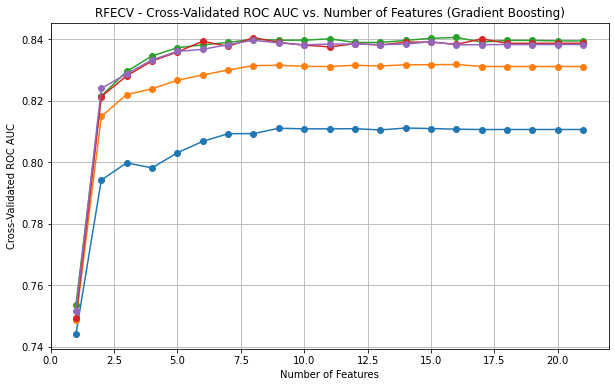

In [43]:
# Plot the cross-validated roc_auc vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated ROC AUC vs. Number of Features (Gradient Boosting)")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated ROC AUC")
plt.grid(True)

# Plot the curve of cross-validated roc_auc
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()

Agency and WorkflowStatus identified as importantant features, similar to RandomForest RFE.

ProductGroup, NoOfLives, BonusCommissionPercentage, and SignedDecReceived also worth consideration - similar to GBC analysis on imbalanced dataset.

#### LightGBM

In [44]:
# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=lgb_classifier, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)
    

Selected features:
Product
ProductGroup
Agency
WorkflowStatus
Indexation
NoOfLives
CommDateProvided
UWDecision
CommissionSacrificePercentage
CommissionTerms
BonusCommissionPercentage
SeriousIllnessType
SignedDecReceived


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


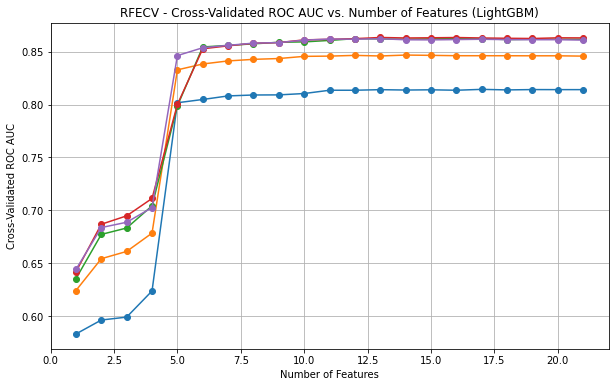

In [45]:
# Plot the cross-validated roc_auc vs. number of selected features
plt.figure(figsize=(10, 6))
plt.title("RFECV - Cross-Validated ROC AUC vs. Number of Features (LightGBM)")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated ROC AUC")
plt.grid(True)

# Plot the curve of cross-validated roc_auc
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')

plt.show()

Similar to the above with the exception of Indexation, CommissionSacrificePercentage and CommissionSacrificePercentage

#### Cramer's V on balanced data

In [46]:
combined_data = np.hstack((X_train_resampled, y_train_resampled.values.reshape(-1, 1)))

# Convert combined_data to a DataFrame
train_data = pd.DataFrame(combined_data, columns=list(X_train.columns) + ['PolicyIssued'])


In [47]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156676 entries, 0 to 156675
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Product                        156676 non-null  float64
 1   ProductGroup                   156676 non-null  float64
 2   ProductType                    156676 non-null  float64
 3   Agency                         156676 non-null  float64
 4   WorkflowStatus                 156676 non-null  float64
 5   Indexation                     156676 non-null  float64
 6   NoOfLives                      156676 non-null  float64
 7   CommDateProvided               156676 non-null  float64
 8   PaymentFreq                    156676 non-null  float64
 9   UWDecision                     156676 non-null  float64
 10  ComissionSacrifice             156676 non-null  float64
 11  CommissionSacrificeType        156676 non-null  float64
 12  RenewalSacrificeType          

In [48]:
train_data.head()

,Product,ProductGroup,ProductType,Agency,WorkflowStatus,Indexation,NoOfLives,CommDateProvided,PaymentFreq,UWDecision,...,RenewalSacrificeType,CommissionSacrificePercentage,CommissionTerms,Discount,BonusCommission,BonusCommissionPercentage,FreeCover,SeriousIllnessType,SignedDecReceived,PolicyIssued
0,-0.858879,-1.068280,0.079233,-0.624052,-1.015368,-0.522535,0.858096,-0.493742,0.059791,1.459405,...,-0.144354,-0.375113,2.685044,-0.093917,0.992517,1.058566,-0.103758,0.119399,-0.699464,0.0
1,1.007433,0.943983,0.079233,-0.091395,0.960467,1.913749,-1.165371,-0.493742,0.059791,-0.711984,...,-0.144354,-0.375113,-0.372433,-0.093917,0.992517,1.417972,-0.103758,0.119399,1.429666,1.0
2,1.007433,0.943983,0.079233,-0.723773,-1.015368,-0.522535,0.858096,-0.493742,0.059791,-0.711984,...,-0.144354,-0.375113,-0.372433,-0.093917,-1.007540,-0.971538,-0.103758,0.119399,-0.699464,1.0
3,-0.858879,-1.068280,0.079233,2.112198,0.960467,-0.522535,-1.165371,-0.493742,0.059791,-0.711984,...,-0.144354,-0.375113,2.685044,-0.093917,-1.007540,-0.971538,-0.103758,0.119399,1.429666,1.0
4,-0.858879,-1.068280,0.079233,-1.361016,-1.015368,-0.522535,0.858096,-0.493742,0.059791,-0.711984,...,-0.144354,-0.375113,-0.372433,-0.093917,-1.007540,-0.971538,-0.103758,0.119399,-0.699464,1.0


In [49]:
for column1 in train_data:
    for column2 in train_data:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            print(f"Chi-square Test: {column1} vs. {column2}")
            print(f"Chi2 Statistic: {chi2}")
            print(f"P-value: {p_value}")
            print()


Chi-square Test: Product vs. ProductGroup
Chi2 Statistic: 39639027.99999997
P-value: 0.0

Chi-square Test: Product vs. ProductType
Chi2 Statistic: 1880111.9999999995
P-value: 0.0

Chi-square Test: Product vs. Agency
Chi2 Statistic: 62174290.09312334
P-value: 0.0

Chi-square Test: Product vs. WorkflowStatus
Chi2 Statistic: 3931794.152445227
P-value: 0.0

Chi-square Test: Product vs. Indexation
Chi2 Statistic: 3170139.386896411
P-value: 0.0

Chi-square Test: Product vs. NoOfLives
Chi2 Statistic: 5199747.277993322
P-value: 0.0

Chi-square Test: Product vs. CommDateProvided
Chi2 Statistic: 158293.95212137338
P-value: 0.0

Chi-square Test: Product vs. PaymentFreq
Chi2 Statistic: 166350.2114822643
P-value: 0.0

Chi-square Test: Product vs. UWDecision
Chi2 Statistic: 4560811.780356105
P-value: 0.0

Chi-square Test: Product vs. ComissionSacrifice
Chi2 Statistic: 476538.4669632408
P-value: 0.0

Chi-square Test: Product vs. CommissionSacrificeType
Chi2 Statistic: 325761.7983753228
P-value: 0.0



Chi-square Test: WorkflowStatus vs. Agency
Chi2 Statistic: 52267226.262984104
P-value: 0.0

Chi-square Test: WorkflowStatus vs. Indexation
Chi2 Statistic: 941541.5571640808
P-value: 0.0

Chi-square Test: WorkflowStatus vs. NoOfLives
Chi2 Statistic: 7209149.89712462
P-value: 0.0

Chi-square Test: WorkflowStatus vs. CommDateProvided
Chi2 Statistic: 1610751.4178468883
P-value: 0.0

Chi-square Test: WorkflowStatus vs. PaymentFreq
Chi2 Statistic: 3619.7942473484154
P-value: 2.269542395297021e-296

Chi-square Test: WorkflowStatus vs. UWDecision
Chi2 Statistic: 12917753.9095668
P-value: 0.0

Chi-square Test: WorkflowStatus vs. ComissionSacrifice
Chi2 Statistic: 1208.3038253559184
P-value: 1.0

Chi-square Test: WorkflowStatus vs. CommissionSacrificeType
Chi2 Statistic: 4462.804946532378
P-value: 1.0

Chi-square Test: WorkflowStatus vs. RenewalSacrificeType
Chi2 Statistic: 5104.274758180656
P-value: 1.0

Chi-square Test: WorkflowStatus vs. CommissionSacrificePercentage
Chi2 Statistic: 20435226.

Chi-square Test: PaymentFreq vs. Agency
Chi2 Statistic: 160116.15017499842
P-value: 0.0

Chi-square Test: PaymentFreq vs. WorkflowStatus
Chi2 Statistic: 3619.794247348415
P-value: 2.269542395297539e-296

Chi-square Test: PaymentFreq vs. Indexation
Chi2 Statistic: 5528.962292102711
P-value: 0.0

Chi-square Test: PaymentFreq vs. NoOfLives
Chi2 Statistic: 12671.782820739298
P-value: 0.0

Chi-square Test: PaymentFreq vs. CommDateProvided
Chi2 Statistic: 982.9057494918317
P-value: 1.8011559969907112e-127

Chi-square Test: PaymentFreq vs. UWDecision
Chi2 Statistic: 163567.0740606157
P-value: 0.0

Chi-square Test: PaymentFreq vs. ComissionSacrifice
Chi2 Statistic: 2018.8814964516966
P-value: 0.0

Chi-square Test: PaymentFreq vs. CommissionSacrificeType
Chi2 Statistic: 2078.031716461476
P-value: 0.0

Chi-square Test: PaymentFreq vs. RenewalSacrificeType
Chi2 Statistic: 158273.31530970923
P-value: 0.0

Chi-square Test: PaymentFreq vs. CommissionSacrificePercentage
Chi2 Statistic: 3852.404727442

Chi-square Test: RenewalSacrificeType vs. ProductGroup
Chi2 Statistic: 479073.903875759
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. ProductType
Chi2 Statistic: 158512.684028394
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. Agency
Chi2 Statistic: 1657817.3746179154
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. WorkflowStatus
Chi2 Statistic: 5104.274758180655
P-value: 1.0

Chi-square Test: RenewalSacrificeType vs. Indexation
Chi2 Statistic: 478977.16249564243
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. NoOfLives
Chi2 Statistic: 173353.02540153
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. CommDateProvided
Chi2 Statistic: 494.498251694536
P-value: 1.0

Chi-square Test: RenewalSacrificeType vs. PaymentFreq
Chi2 Statistic: 158273.31530970923
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. UWDecision
Chi2 Statistic: 326578.3808125063
P-value: 0.0

Chi-square Test: RenewalSacrificeType vs. ComissionSacrifice
Chi2 Statistic: 975821.

Chi-square Test: Discount vs. BonusCommissionPercentage
Chi2 Statistic: 22112.865022223214
P-value: 0.0

Chi-square Test: Discount vs. FreeCover
Chi2 Statistic: 9.023552471857439
P-value: 0.002665229024788562

Chi-square Test: Discount vs. SeriousIllnessType
Chi2 Statistic: 282.16940975717205
P-value: 3.495443640319438e-09

Chi-square Test: Discount vs. SignedDecReceived
Chi2 Statistic: 569.5744489688544
P-value: 1.4301034650930977e-11

Chi-square Test: Discount vs. PolicyIssued
Chi2 Statistic: 7.476855192485379
P-value: 0.0062497135141659395

Chi-square Test: BonusCommission vs. Product
Chi2 Statistic: 493288.7789157197
P-value: 0.0

Chi-square Test: BonusCommission vs. ProductGroup
Chi2 Statistic: 476975.81887905684
P-value: 0.0

Chi-square Test: BonusCommission vs. ProductType
Chi2 Statistic: 20115.256492582164
P-value: 0.0

Chi-square Test: BonusCommission vs. Agency
Chi2 Statistic: 12924750.46574524
P-value: 0.0

Chi-square Test: BonusCommission vs. WorkflowStatus
Chi2 Statistic: 

Chi-square Test: SeriousIllnessType vs. UWDecision
Chi2 Statistic: 1573242.5544032464
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. ComissionSacrifice
Chi2 Statistic: 2557.5392920183017
P-value: 3.221243447836291e-14

Chi-square Test: SeriousIllnessType vs. CommissionSacrificeType
Chi2 Statistic: 11974.627976684726
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. RenewalSacrificeType
Chi2 Statistic: 10412.700800151979
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. CommissionSacrificePercentage
Chi2 Statistic: 9724812.19097524
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. CommissionTerms
Chi2 Statistic: 627521.7681871374
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. Discount
Chi2 Statistic: 282.16940975717205
P-value: 3.495443640319438e-09

Chi-square Test: SeriousIllnessType vs. BonusCommission
Chi2 Statistic: 504402.69660987105
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. BonusCommissionPercentage
Chi2 Statistic: 504402.69660987105
P-value:

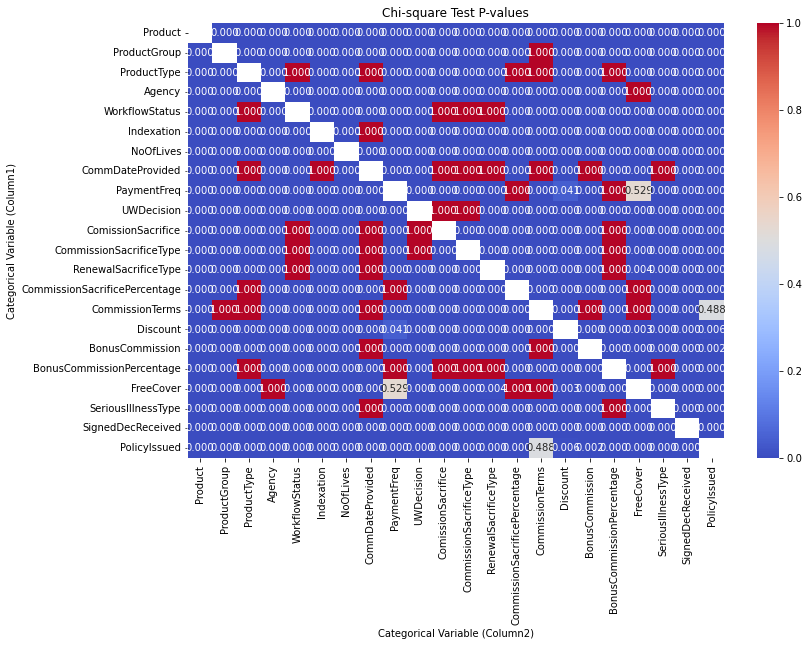

In [50]:
# Initialise an empty DataFrame to store p-values
p_values_df = pd.DataFrame(index=train_data.columns, columns=train_data.columns)

# Loop through each pair of columns and calculate chi-square test p-values
for column1 in train_data.columns:
    for column2 in train_data.columns:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            p_values_df.loc[column1, column2] = p_value

# Convert p-values to numeric format
p_values_df = p_values_df.apply(pd.to_numeric)

# Create a heatmap to visualize p-values
plt.figure(figsize=(12, 8))
sns.heatmap(p_values_df, cmap='coolwarm', annot=True, fmt=".3f")
plt.title("Chi-square Test P-values")
plt.xlabel("Categorical Variable (Column2)")
plt.ylabel("Categorical Variable (Column1)")
plt.show()


In [51]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = np.sum(confusion_matrix)
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corrected = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corrected = r - ((r - 1) ** 2) / (n - 1)
    k_corrected = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corrected / min((k_corrected - 1), (r_corrected - 1)))

# Calculate Cramer's V for variables
for column1 in train_data:
    for column2 in train_data:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            v = cramers_v(contingency_table.values)
            print(f"{column1} vs. {column2}")
            print(f"Cramer's V: {v}")
            print(f"Chi2 Statistic: {chi2}")
            print(f"P-value: {p_value}")
            print()
            

Product vs. ProductGroup
Cramer's V: 0.9992805328880286
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. ProductType
Cramer's V: 0.9985116235167488
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. Agency
Cramer's V: 0.8001513426282002
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. WorkflowStatus
Cramer's V: 0.22249612338357413
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. Indexation
Cramer's V: 0.35489794774854205
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. NoOfLives
Cramer's V: 0.25756495357086767
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. CommDateProvided
Cramer's V: 0.10768761364584399
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. PaymentFreq
Cramer's V: 0.7265185063754445
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. UWDecision
Cramer's V: 0.23091071572841115
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Product vs. ComissionSacrifice
Cramer's V: 0.48055585419620

Agency vs. CommissionTerms
Cramer's V: 0.86858726566888
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. Discount
Cramer's V: 0.30434417702496447
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. BonusCommission
Cramer's V: 0.8515304322851579
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. BonusCommissionPercentage
Cramer's V: 0.7414794182353182
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. FreeCover
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. SeriousIllnessType
Cramer's V: 0.8549923460726586
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. SignedDecReceived
Cramer's V: 0.7385713721541982
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

Agency vs. PolicyIssued
Cramer's V: 0.37070202349159204
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

WorkflowStatus vs. Product
Cramer's V: 0.22249612338357413
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

WorkflowStatus vs. ProductGroup
Cramer's V: 0.201780

CommDateProvided vs. NoOfLives
Cramer's V: 0.10623071362454911
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. PaymentFreq
Cramer's V: 0.05192666643273113
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. UWDecision
Cramer's V: 0.3526774692308085
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. ComissionSacrifice
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. CommissionSacrificeType
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. RenewalSacrificeType
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. CommissionSacrificePercentage
Cramer's V: 0.5173066503253841
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. CommissionTerms
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommDateProvided vs. Discount
Cramer's V: 0.030182045181818756
Chi2 Statistic: 2521.2118473433775
P-value: 

CommissionSacrificeType vs. Product
Cramer's V: 0.41258861669710284
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. ProductGroup
Cramer's V: 0.4132559738180139
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. ProductType
Cramer's V: 0.04129524208843338
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. Agency
Cramer's V: 0.848143939291555
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. WorkflowStatus
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. Indexation
Cramer's V: 0.5042970002427856
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. NoOfLives
Cramer's V: 0.073619926975867
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. CommDateProvided
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionSacrificeType vs. PaymentFreq
Cramer's V: 0.08096365263658635
C

CommissionTerms vs. CommDateProvided
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. PaymentFreq
Cramer's V: 0.10465029167645937
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. UWDecision
Cramer's V: 0.2635891530854483
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. ComissionSacrifice
Cramer's V: 0.277282413252228
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. CommissionSacrificeType
Cramer's V: 0.2936833550140466
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. RenewalSacrificeType
Cramer's V: 0.39576442550889473
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. CommissionSacrificePercentage
Cramer's V: 0.5553424646786768
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. Discount
Cramer's V: 0.057253640435052
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

CommissionTerms vs. BonusCommission
Cramer's V: 0.0
Chi2 Statistic: 2521

BonusCommissionPercentage vs. BonusCommission
Cramer's V: 0.9764608276814256
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

BonusCommissionPercentage vs. FreeCover
Cramer's V: 0.09815485691712725
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

BonusCommissionPercentage vs. SeriousIllnessType
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

BonusCommissionPercentage vs. SignedDecReceived
Cramer's V: 0.24188438999168774
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

BonusCommissionPercentage vs. PolicyIssued
Cramer's V: 0.1196801033908206
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

FreeCover vs. Product
Cramer's V: 0.11922458528089726
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

FreeCover vs. ProductGroup
Cramer's V: 0.12363348079097326
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

FreeCover vs. ProductType
Cramer's V: 0.029352648470634835
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

FreeCover vs. Agency
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433

PolicyIssued vs. PaymentFreq
Cramer's V: 0.01473325478743392
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. UWDecision
Cramer's V: 0.3948913092575033
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. ComissionSacrifice
Cramer's V: 0.01970668859440392
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. CommissionSacrificeType
Cramer's V: 0.02073814296845586
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. RenewalSacrificeType
Cramer's V: 0.023115574073658943
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. CommissionSacrificePercentage
Cramer's V: 0.11531780921649011
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. CommissionTerms
Cramer's V: 0.0
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. Discount
Cramer's V: 0.00642957146674295
Chi2 Statistic: 2521.2118473433775
P-value: 0.0

PolicyIssued vs. BonusCommission
Cramer's V: 0.016835178585339994
Chi2 Statistic: 2521.211

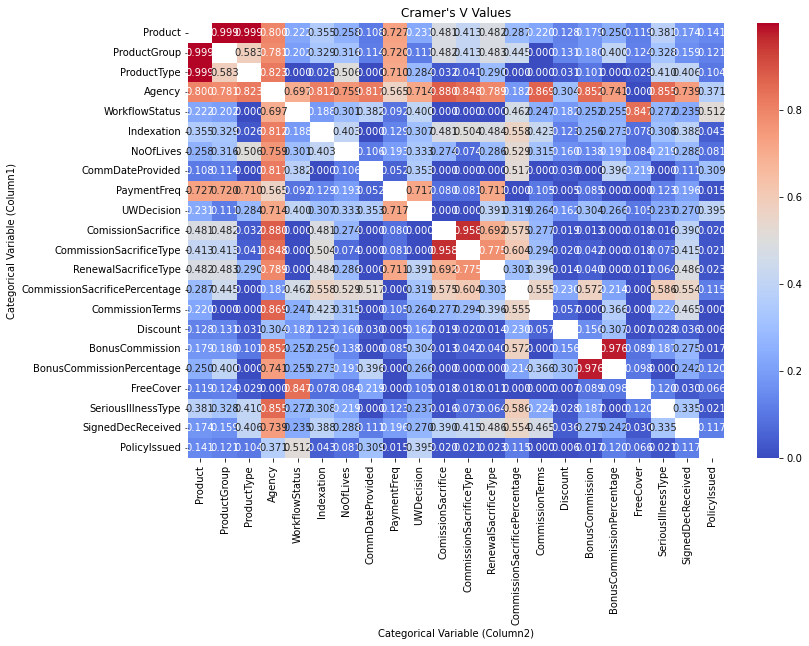

In [52]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = np.sum(confusion_matrix)
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corrected = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corrected = r - ((r - 1) ** 2) / (n - 1)
    k_corrected = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corrected / min((k_corrected - 1), (r_corrected - 1)))

# Initialise an empty DataFrame to store Cramer's V values
cramers_v_df = pd.DataFrame(index=train_data.columns, columns=train_data.columns)

# Loop through each pair of columns and calculate Cramer's V values
for column1 in train_data.columns:
    for column2 in train_data.columns:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            v = cramers_v(contingency_table.values)
            cramers_v_df.loc[column1, column2] = v

# Convert Cramer's V values to numeric format
cramers_v_df = cramers_v_df.apply(pd.to_numeric)

# Create a heatmap to visualize Cramer's V values
plt.figure(figsize=(12, 8))
sns.heatmap(cramers_v_df, cmap='coolwarm', annot=True, fmt=".3f")
plt.title("Cramer's V Values")
plt.xlabel("Categorical Variable (Column2)")
plt.ylabel("Categorical Variable (Column1)")
plt.show()


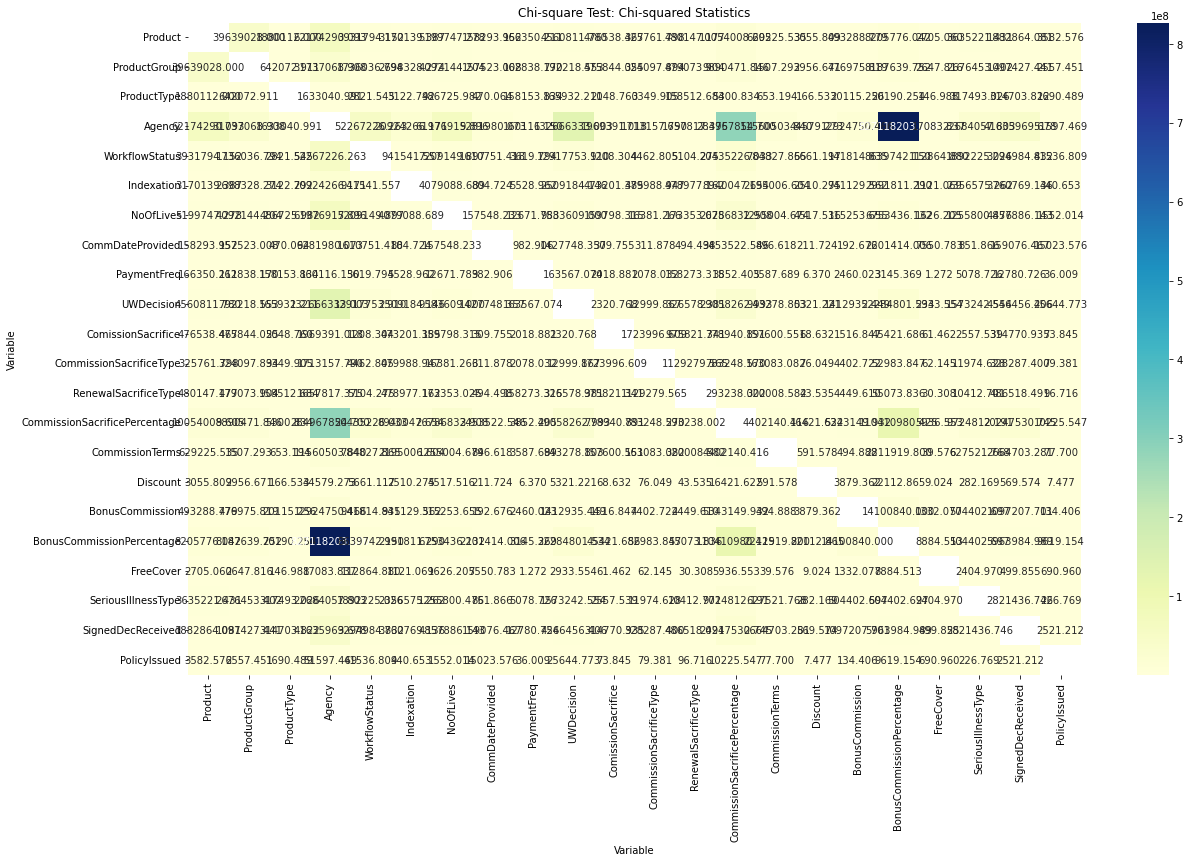

In [53]:
# Create an empty dataframe to store Chi-squared statistics
chi2_stats_df = pd.DataFrame(index=train_data.select_dtypes(include='float64').columns, columns=train_data.select_dtypes(include='float64').columns)

# Perform chi-square test for each pair of categorical variables
for column1 in train_data:
    for column2 in train_data:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2_stat, _, _, _ = chi2_contingency(contingency_table)
            chi2_stats_df.loc[column1, column2] = chi2_stat

# Create a heatmap of the Chi-squared statistics
plt.figure(figsize=(20, 12))
sns.heatmap(chi2_stats_df.astype(float), annot=True, fmt=".3f", cmap='YlGnBu')
plt.xlabel('Variable')
plt.ylabel('Variable')
plt.title('Chi-square Test: Chi-squared Statistics')
plt.show()


When calculated on the balanced dataset, PolicyIssued still seems to have stronger associations with variables like WorkflowStatus, UWDecision, CommDateProvided and Agency.

### Feature Selection Conclusions

Agency and WorkflowStatus occur in the majority of the analyses, implying that they are the most essential variables for predicting the conversion of life assurance apps. UWDecision and CommDateProvided might also be considered because they occur consistently in various techniques. These features might serve as a solid starting point for developing a predictive model. 

#### Imbalanced Dataset

In [28]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import lightgbm as lgb

selected_features = ['Agency', 'WorkflowStatus', 'UWDecision','CommDateProvided','SignedDecReceived']

# Split the data into features (X) and the target variable (y)
X = df[selected_features]
y = df['PolicyIssued']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialise and train a Decision Tree model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

# Make predictions with the Decision Tree model
tree_predictions = tree_model.predict(X_test)
tree_probabilities = tree_model.predict_proba(X_test)[:, 1]

# Calculate accuracy for Decision Tree
tree_accuracy = accuracy_score(y_test, tree_predictions)

# Calculate ROC AUC score for Decision Tree
tree_roc_auc = roc_auc_score(y_test, tree_probabilities)

print("Decision Tree Accuracy:", tree_accuracy)
print("Decision Tree ROC AUC:", tree_roc_auc)
print(classification_report(y_test, tree_predictions))

# Initialize and train a Random Forest model
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

# Make predictions with the Random Forest model
forest_predictions = forest_model.predict(X_test)
forest_probabilities = forest_model.predict_proba(X_test)[:, 1]

# Calculate accuracy for Random Forest
forest_accuracy = accuracy_score(y_test, forest_predictions)

# Calculate ROC AUC score for Random Forest
forest_roc_auc = roc_auc_score(y_test, forest_probabilities)

print("Random Forest Accuracy:", forest_accuracy)
print("Random Forest ROC AUC:", forest_roc_auc)
print(classification_report(y_test, forest_predictions))




selected_features = ['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup'
                     , 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives'
                     , 'ProductType', 'SignedDecReceived', 'Indexation']

# Split the data into features (X) and the target variable (y)
X = df[selected_features]
y = df['PolicyIssued']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Gradient Boosting model
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Make predictions with the Gradient Boosting model
gb_predictions = gb_model.predict(X_test)
gb_probabilities = gb_model.predict_proba(X_test)[:, 1]

# Calculate accuracy for Gradient Boosting
gb_accuracy = accuracy_score(y_test, gb_predictions)

# Calculate ROC AUC score for Gradient Boosting
gb_roc_auc = roc_auc_score(y_test, gb_probabilities)

print("Gradient Boosting Accuracy:", gb_accuracy)
print("Gradient Boosting ROC AUC:", gb_roc_auc)
print(classification_report(y_test, gb_predictions))




selected_features = ['Agency', 'UWDecision', 'CommDateProvided', 'SignedDecReceived'
                     , 'ProductType', 'WorkflowStatus', 'NoOfLives', 'ProductGroup'
                     , 'BonusCommission', 'Product', 'SeriousIllnessType']

# Split the data into features (X) and the target variable (y)
X = df[selected_features]
y = df['PolicyIssued']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a LightGBM model
lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(X_train, y_train)

# Make predictions with the LightGBM model
lgb_predictions = lgb_classifier.predict(X_test)
lgb_probabilities = lgb_classifier.predict_proba(X_test)[:, 1]

# Calculate accuracy for LightGBM
lgb_accuracy = accuracy_score(y_test, lgb_predictions)

# Calculate ROC AUC score for LightGBM
lgb_roc_auc = roc_auc_score(y_test, lgb_probabilities)

print("LightGBM Accuracy:", lgb_accuracy)
print("LightGBM Boosting ROC AUC:", lgb_roc_auc)
print(classification_report(y_test, lgb_predictions))

Decision Tree Accuracy: 0.7948096335744377
Decision Tree ROC AUC: 0.7896688407459994
              precision    recall  f1-score   support

           0       0.55      0.41      0.47      5577
           1       0.84      0.90      0.87     19585

    accuracy                           0.79     25162
   macro avg       0.70      0.66      0.67     25162
weighted avg       0.78      0.79      0.78     25162

Random Forest Accuracy: 0.7989031078610603
Random Forest ROC AUC: 0.7977573057657895
              precision    recall  f1-score   support

           0       0.57      0.40      0.47      5577
           1       0.84      0.91      0.88     19585

    accuracy                           0.80     25162
   macro avg       0.70      0.65      0.67     25162
weighted avg       0.78      0.80      0.79     25162

Gradient Boosting Accuracy: 0.8022812177092441
Gradient Boosting ROC AUC: 0.8120687427103247
              precision    recall  f1-score   support

           0       0.65     

In [30]:
# List of features to test
features_to_test = ['Agency', 'WorkflowStatus', 'UWDecision','CommDateProvided','SignedDecReceived']

# Define hypotheses
hypotheses = {
    'Agency': "The presence of the 'Agency' feature has a positive impact.",
    'WorkflowStatus': "The presence of the 'WorkflowStatus' feature has a positive impact.",
    'UWDecision': "The presence of the 'UWDecision' feature has a positive impact.",
    'CommDateProvided': "The presence of the 'CommDateProvided' feature has a positive impact",
    'SignedDecReceived': "The presence of the 'SignedDecReceived' feature has a positive impact."
}

# Split the data into features (X) and the target variable (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Initialise empty dictionaries to store results
accuracy_results = {}
roc_auc_results = {}

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialise models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
}

# Loop through each feature to test
for feature in features_to_test:
    # Initialise dictionaries to store results for this feature
    accuracy_feature_results = {}
    roc_auc_feature_results = {}

    # Create control group (without feature manipulation)
    X_control = X_test.copy()

    for model_name, model in models.items():
        # Train the model on the control group
        model.fit(X_train, y_train)

        # Make predictions on the control group
        control_predictions = model.predict(X_control)
        control_probabilities = model.predict_proba(X_control)[:, 1]

        # Calculate accuracy and ROC AUC for the control group
        control_accuracy = accuracy_score(y_test, control_predictions)
        control_roc_auc = roc_auc_score(y_test, control_probabilities)

        accuracy_feature_results[f'Control - {model_name}'] = control_accuracy
        roc_auc_feature_results[f'Control - {model_name}'] = control_roc_auc

        # Create experimental group (with feature manipulation)
        X_experiment = X_test.copy()
        X_experiment[feature] = 0  # Manipulate the feature as per hypothesis

        # Make predictions on the experimental group
        experiment_predictions = model.predict(X_experiment)
        experiment_probabilities = model.predict_proba(X_experiment)[:, 1]

        # Calculate accuracy and ROC AUC for the experimental group
        experiment_accuracy = accuracy_score(y_test, experiment_predictions)
        experiment_roc_auc = roc_auc_score(y_test, experiment_probabilities)

        accuracy_feature_results[f'Experiment - {model_name}'] = experiment_accuracy
        roc_auc_feature_results[f'Experiment - {model_name}'] = experiment_roc_auc

    # Store the results for this feature
    accuracy_results[feature] = accuracy_feature_results
    roc_auc_results[feature] = roc_auc_feature_results

# Conduct t-tests to determine statistical significance
statistical_significance = {}
for feature in features_to_test:
    accuracy_control_values = list(accuracy_results[feature].values())[:len(models)]
    accuracy_experiment_values = list(accuracy_results[feature].values())[len(models):]

    roc_auc_control_values = list(roc_auc_results[feature].values())[:len(models)]
    roc_auc_experiment_values = list(roc_auc_results[feature].values())[len(models):]

    # Perform t-tests for accuracy and ROC AUC
    accuracy_p_value = ttest_ind(accuracy_control_values, accuracy_experiment_values).pvalue
    roc_auc_p_value = ttest_ind(roc_auc_control_values, roc_auc_experiment_values).pvalue

    # Store p-values for each feature
    statistical_significance[feature] = {
        'Accuracy p-value': accuracy_p_value,
        'ROC AUC p-value': roc_auc_p_value
    }

# Print results and statistical significance
for feature, results in accuracy_results.items():
    print(f"Feature: {feature}")
    for model_name, accuracy in results.items():
        print(f"{model_name} - Accuracy: {accuracy:.4f}")

for feature, results in roc_auc_results.items():
    print(f"Feature: {feature}")
    for model_name, roc_auc in results.items():
        print(f"{model_name} - ROC AUC: {roc_auc:.4f}")

for feature, p_values in statistical_significance.items():
    print(f"Statistical Significance for {feature}:")
    print(f"Accuracy p-value: {p_values['Accuracy p-value']:.4f}")
    print(f"ROC AUC p-value: {p_values['ROC AUC p-value']:.4f}")


Feature: Agency
Control - Decision Tree - Accuracy: 0.7648
Experiment - Decision Tree - Accuracy: 0.7469
Control - Random Forest - Accuracy: 0.7771
Experiment - Random Forest - Accuracy: 0.7579
Control - Gradient Boosting - Accuracy: 0.8020
Experiment - Gradient Boosting - Accuracy: 0.7833
Feature: WorkflowStatus
Control - Decision Tree - Accuracy: 0.7637
Experiment - Decision Tree - Accuracy: 0.5892
Control - Random Forest - Accuracy: 0.7775
Experiment - Random Forest - Accuracy: 0.6569
Control - Gradient Boosting - Accuracy: 0.8020
Experiment - Gradient Boosting - Accuracy: 0.7128
Feature: UWDecision
Control - Decision Tree - Accuracy: 0.7645
Experiment - Decision Tree - Accuracy: 0.7535
Control - Random Forest - Accuracy: 0.7769
Experiment - Random Forest - Accuracy: 0.7739
Control - Gradient Boosting - Accuracy: 0.8020
Experiment - Gradient Boosting - Accuracy: 0.7977
Feature: CommDateProvided
Control - Decision Tree - Accuracy: 0.7648
Experiment - Decision Tree - Accuracy: 0.7614


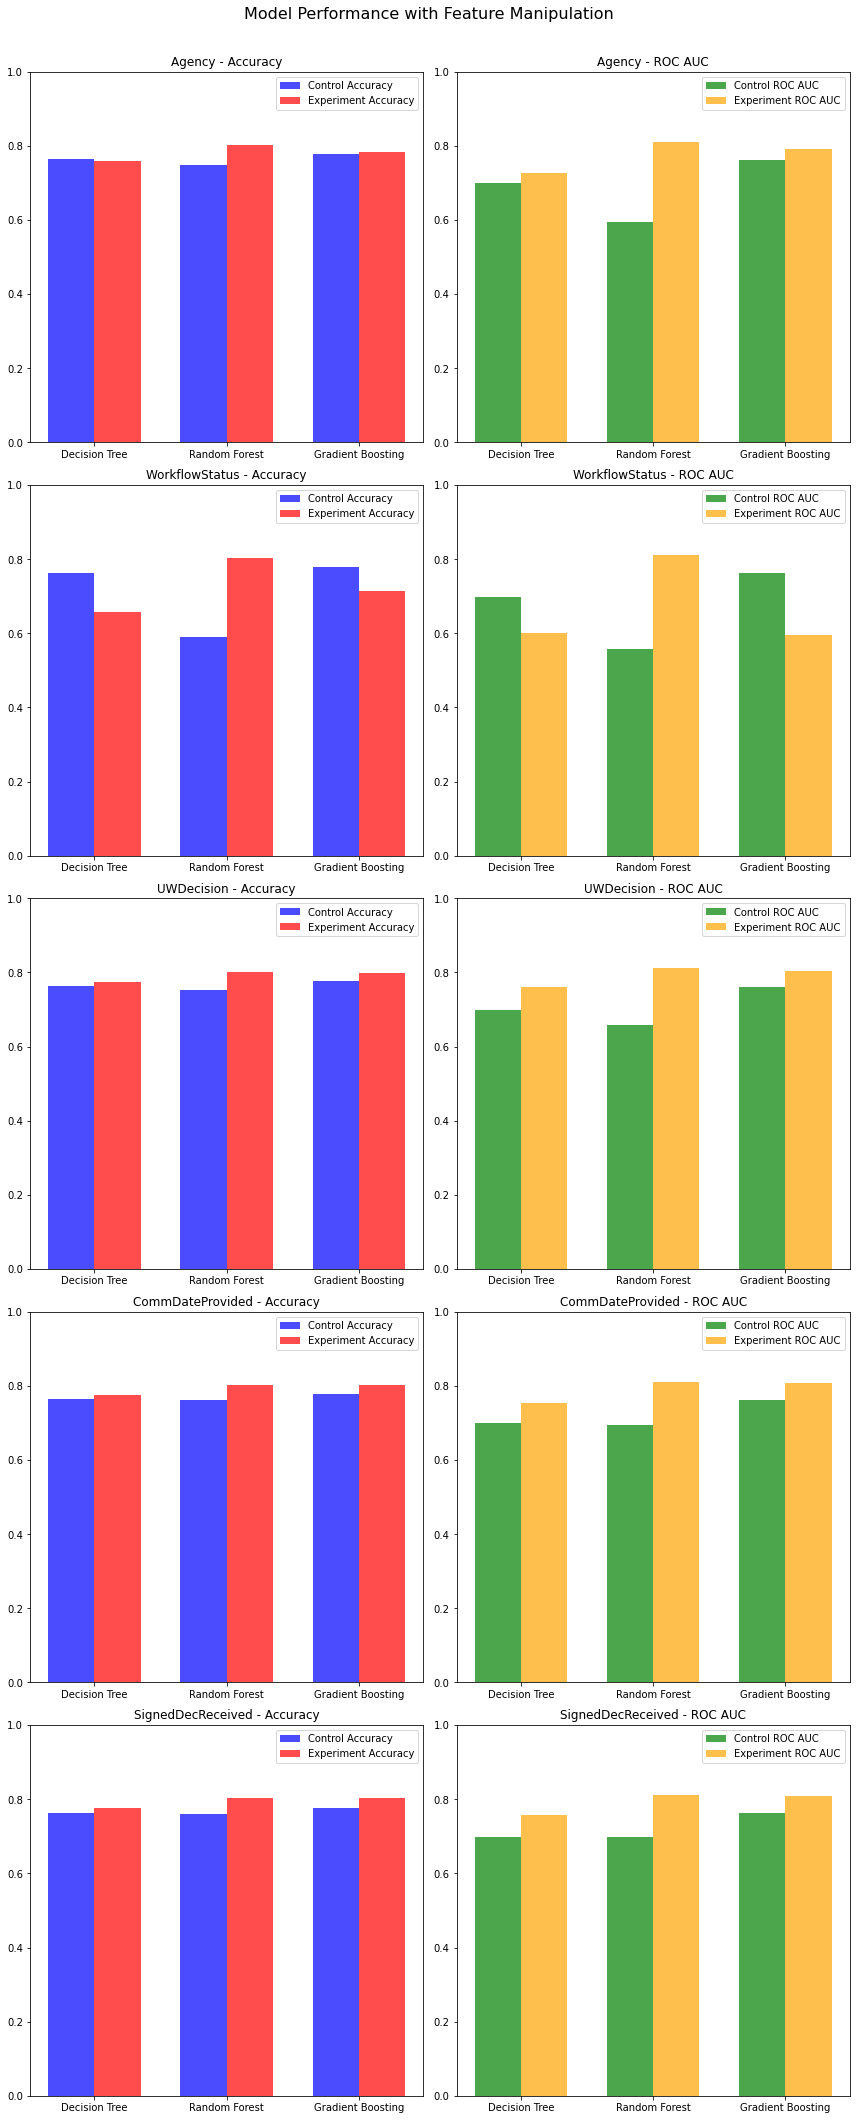

In [31]:
# Create a function to visualise the results
def plot_results(features, metrics, title):
    fig, axs = plt.subplots(len(features), 2, figsize=(12, 6 * len(features)))
    fig.suptitle(title, fontsize=16)
    
    for i, feature in enumerate(features):
        # Accuracy Results
        accuracy_control_values = metrics[feature]['Control']['Accuracy']
        accuracy_experiment_values = metrics[feature]['Experiment']['Accuracy']
        models = metrics[feature]['Models']
        
        bar_width = 0.35
        index = np.arange(len(models))
        
        axs[i, 0].bar(index - bar_width/2, accuracy_control_values, bar_width, color='blue', alpha=0.7, label='Control Accuracy')
        axs[i, 0].bar(index + bar_width/2, accuracy_experiment_values, bar_width, color='red', alpha=0.7, label='Experiment Accuracy')
        axs[i, 0].set_title(f'{feature} - Accuracy')
        axs[i, 0].set_ylim(0, 1)
        axs[i, 0].set_xticks(index)
        axs[i, 0].set_xticklabels(models)
        axs[i, 0].legend()
        
        # ROC AUC Results
        roc_auc_control_values = metrics[feature]['Control']['ROC AUC']
        roc_auc_experiment_values = metrics[feature]['Experiment']['ROC AUC']
        
        axs[i, 1].bar(index - bar_width/2, roc_auc_control_values, bar_width, color='green', alpha=0.7, label='Control ROC AUC')
        axs[i, 1].bar(index + bar_width/2, roc_auc_experiment_values, bar_width, color='orange', alpha=0.7, label='Experiment ROC AUC')
        axs[i, 1].set_title(f'{feature} - ROC AUC')
        axs[i, 1].set_ylim(0, 1)
        axs[i, 1].set_xticks(index)
        axs[i, 1].set_xticklabels(models)
        axs[i, 1].legend()
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Store results in a more structured format
metrics = {}

for feature in features_to_test:
    accuracy_control_values = list(accuracy_results[feature].values())[:len(models)]
    accuracy_experiment_values = list(accuracy_results[feature].values())[len(models):]
    
    roc_auc_control_values = list(roc_auc_results[feature].values())[:len(models)]
    roc_auc_experiment_values = list(roc_auc_results[feature].values())[len(models):]

    # Store accuracy and ROC AUC results for each feature and model type
    metrics[feature] = {
        'Models': [model_name for model_name in models.keys()],
        'Control': {
            'Accuracy': accuracy_control_values,
            'ROC AUC': roc_auc_control_values
        },
        'Experiment': {
            'Accuracy': accuracy_experiment_values,
            'ROC AUC': roc_auc_experiment_values
        }
    }

# Create clustered column charts
plot_results(features_to_test, metrics, 'Model Performance with Feature Manipulation')
